In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

## **Define Functions for Simulations**

In [214]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [6]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [14]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,single_param=None):
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    for c in range(clus):
        marks = all_choices[c*num_marks:(c+1)*num_marks]

        #UPDATE to change either b or beta&gamma
        for m in marks:
            if np.random.rand() < p:
                params[c,m,0] += loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1) #Only in burst size
            elif single_param == 'beta':
                params[c,m,2] -= loc+np.random.randn()*0.1
            elif single_param == 'gamma':
                params[c,m,3] -= loc+np.random.randn()*0.1
            else: 
                params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                params[c,m,3] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)

    return params,all_choices


In [15]:
def make_counts(clus,n_cells,n_genes,params):
    all_counts = np.zeros((clus*n_cells,n_genes,2))
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
            #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
            #max_domain = [int(i) for i in max_domain]

            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells, Pss)
            all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
            all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]
            
    return all_counts

In [65]:
#No. of cells per k cell 'type'
n_cells = 500
clus = 3

In [66]:
n_genes = 100
num_marks = 10

In [67]:
#Technical sampling params
glob_samp = np.asarray([-7.157894736842105, -1.525])

In [68]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]

In [69]:
#Initialize params and correlations
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L .... b=1 before
std = np.asarray([0.6, 0.3, 0.5, 0.5]) # for b, was 0.6
var = std[:, None] * std[None, :]
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
samples = np.random.multivariate_normal(mean, var, n_genes)


In [70]:
samples.shape

(100, 4)

In [71]:
#Select genes from real transcriptome

gene_names = np.array(transcriptome[0])

names_sub = gene_names[0:n_genes]
#lens_sub = gene_lens[choices]

transcriptome_sub = transcriptome[0:n_genes]
lens_sub = 10**samples[:,3]
transcriptome_sub[1] = [int(i) for i in lens_sub]
transcriptome_sub.head()

#make new transcriptome in same style
transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3',sep=' ', index=False)

# # Test transcriptome looks ok
# df_read = pd.read_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3', delim_whitespace=True)
# df_read


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [72]:
all_params = []
all_marks = []
ps = [(1.0,1.0),(0.45,1.0),
      (0.1,1.5),(0.1,1.0),
      (0,1.5),(0,1.0)] #Test different simulation scenarios, (1.0,1.5),(0.45,1.5), too easy
sing_params = [None]*2+['beta']*4
for j in range(len(ps)):
    p = ps[j]
    out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=p[0],loc=p[1],single_param=sing_params[j])
    all_params += [out[0]]
    all_marks += [out[1]]


In [73]:
all_counts = []
for params in all_params:
    all_counts += [make_counts(clus,n_cells,n_genes,params)]

In [74]:
all_assigns = []
for c in range(clus):
    all_assigns += [c]*n_cells

**Make sure sims look ok**

Text(0, 0.5, 'log beta (beta)')

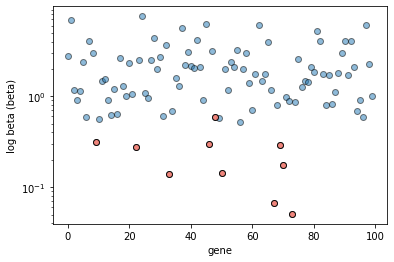

In [77]:
test_out = all_params[-1]
test_marks = all_marks[-1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,2],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,2][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log beta (beta)')

Text(0, 0.5, 'log burst size (b)')

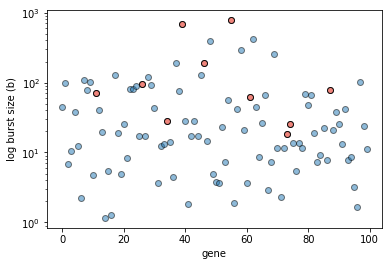

In [78]:
test_out = all_params[0]
test_marks = all_marks[0][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,0],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,0][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log burst size (b)')

[[1.         0.95118497]
 [0.95118497 1.        ]]


Text(0, 0.5, 'param mean U')

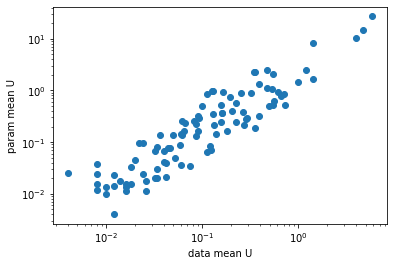

In [79]:
#Check relationship between means and means from params
k1 = all_counts[0][0:500,:,:]
k1.shape

sim_mean = test_out[0,:,0]+test_out[0,:,4]-test_out[0,:,1]
plt.scatter(np.mean(k1[:,:,0],axis=0),10**sim_mean )
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**(sim_mean )))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('data mean U')
plt.ylabel('param mean U')

In [108]:
test_cluster = all_counts[-1]

In [109]:
concat_types = np.concatenate((np.mean(test_cluster[0:500,:,:],axis=0),np.mean(test_cluster[500:1000,:,:],axis=0),
          np.mean(test_cluster[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '14'),
 Text(1, 1.5, '32'),
 Text(1, 2.5, '41'),
 Text(1, 3.5, '76'),
 Text(1, 4.5, '53'),
 Text(1, 5.5, '1'),
 Text(1, 6.5, '6'),
 Text(1, 7.5, '16'),
 Text(1, 8.5, '47'),
 Text(1, 9.5, '87'),
 Text(1, 10.5, '42'),
 Text(1, 11.5, '83'),
 Text(1, 12.5, '61'),
 Text(1, 13.5, '95'),
 Text(1, 14.5, '89'),
 Text(1, 15.5, '22'),
 Text(1, 16.5, '36'),
 Text(1, 17.5, '43'),
 Text(1, 18.5, '34'),
 Text(1, 19.5, '51'),
 Text(1, 20.5, '70'),
 Text(1, 21.5, '72'),
 Text(1, 22.5, '50'),
 Text(1, 23.5, '68'),
 Text(1, 24.5, '19'),
 Text(1, 25.5, '90'),
 Text(1, 26.5, '82'),
 Text(1, 27.5, '74'),
 Text(1, 28.5, '15'),
 Text(1, 29.5, '67'),
 Text(1, 30.5, '52'),
 Text(1, 31.5, '31'),
 Text(1, 32.5, '78'),
 Text(1, 33.5, '92'),
 Text(1, 34.5, '21'),
 Text(1, 35.5, '33'),
 Text(1, 36.5, '65'),
 Text(1, 37.5, '9'),
 Text(1, 38.5, '73'),
 Text(1, 39.5, '4'),
 Text(1, 40.5, '56'),
 Text(1, 41.5, '49'),
 Text(1, 42.5, '88'),
 Text(1, 43.5, '26'),
 Text(1, 44.5, '25'),
 Text(1, 45.5, '80'),
 T

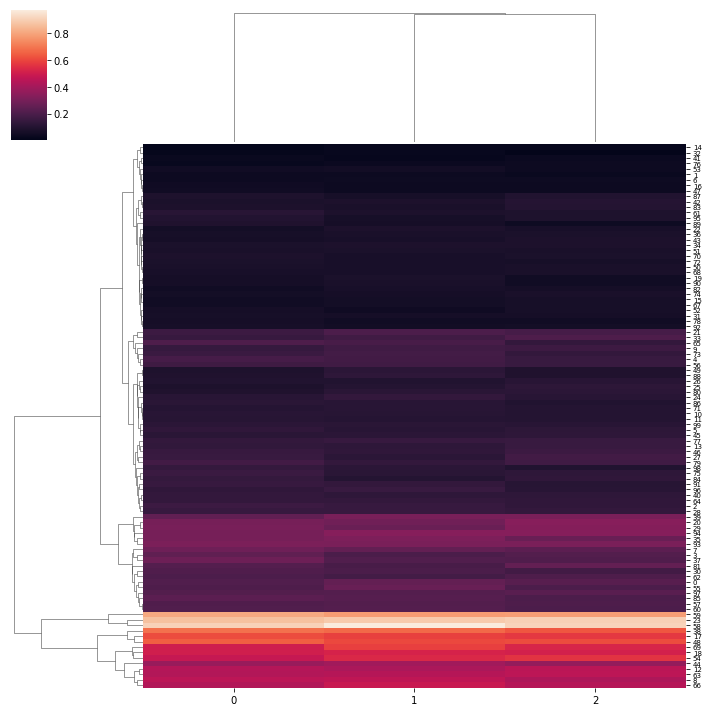

In [110]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[1,3,5]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



[Text(1, 0.5, '29'),
 Text(1, 1.5, '55'),
 Text(1, 2.5, '9'),
 Text(1, 3.5, '69'),
 Text(1, 4.5, '70'),
 Text(1, 5.5, '22'),
 Text(1, 6.5, '67'),
 Text(1, 7.5, '50'),
 Text(1, 8.5, '33'),
 Text(1, 9.5, '48'),
 Text(1, 10.5, '74'),
 Text(1, 11.5, '87'),
 Text(1, 12.5, '8'),
 Text(1, 13.5, '28'),
 Text(1, 14.5, '65'),
 Text(1, 15.5, '77'),
 Text(1, 16.5, '90'),
 Text(1, 17.5, '43'),
 Text(1, 18.5, '97'),
 Text(1, 19.5, '66'),
 Text(1, 20.5, '72'),
 Text(1, 21.5, '88'),
 Text(1, 22.5, '15'),
 Text(1, 23.5, '7'),
 Text(1, 24.5, '21'),
 Text(1, 25.5, '16'),
 Text(1, 26.5, '27'),
 Text(1, 27.5, '44'),
 Text(1, 28.5, '78'),
 Text(1, 29.5, '12'),
 Text(1, 30.5, '93'),
 Text(1, 31.5, '46'),
 Text(1, 32.5, '38'),
 Text(1, 33.5, '81'),
 Text(1, 34.5, '32'),
 Text(1, 35.5, '96'),
 Text(1, 36.5, '31'),
 Text(1, 37.5, '19'),
 Text(1, 38.5, '60'),
 Text(1, 39.5, '76'),
 Text(1, 40.5, '73'),
 Text(1, 41.5, '2'),
 Text(1, 42.5, '56'),
 Text(1, 43.5, '71'),
 Text(1, 44.5, '5'),
 Text(1, 45.5, '3'),
 Tex

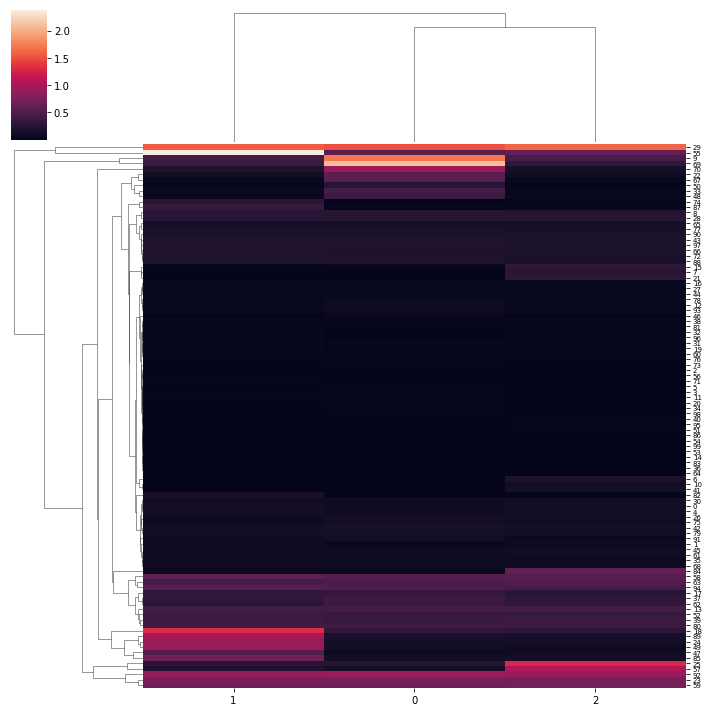

In [111]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[0,2,4]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



Text(0, 0.5, 'Mature counts')

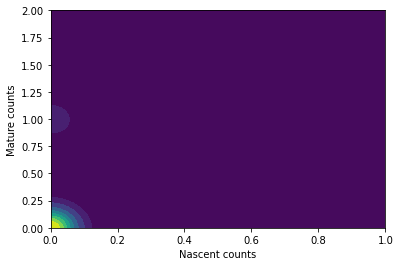

In [84]:
plt.figure()
test_gene = k1[:,50,:]
sns.kdeplot(x=test_gene[:,0], y=test_gene[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test_gene[:,0]),np.max(test_gene[:,0]))
plt.ylim(np.min(test_gene[:,1]),np.max(test_gene[:,1]))
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [44]:
np.max(k1)

187.0

**Save count matrices for Monod**

In [85]:
!mkdir ~/counts/mixMod_sims
!mkdir ~/counts/mixMod_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims’: File exists
mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims/loom/’: File exists


In [86]:
out_names = ['lowest_b_sim','lowest_b_beta_g_sim',
             'beta90_sim','lowest_beta90_sim',
             'beta100_sim','lowest_beta100_sim'] 

In [87]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_sims/loom/'
geneNames = names_sub
for ind in range(len(out_names)):
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(n_cells*clus)]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)


Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_beta_g_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/beta90_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_beta90_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/beta100_sim.loom
Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/mixMod_sims/loom/lowest_beta100_sim.loom


In [88]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[0][0:n_cells,:,0]
S = all_counts[0][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_b_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_b_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [89]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta and gamma sim -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[1][0:n_cells,:,0]
S = all_counts[1][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_b_beta_g_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_b_beta_g_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [90]:
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[3][0:n_cells,:,0]
S = all_counts[3][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_beta90_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_beta90_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [351]:
# #Check loom ok
# ds = lp.connect('/home/tchari/counts/mixMod_sims/loom/b_sim.loom')

In [352]:
# ds

In [353]:
# ds.close()

## **Run Inference**

In [91]:
rep_data = list(np.repeat(out_names,5))+['oneClus_lowest_b_sim']+['oneClus_lowest_b_beta_g_sim']+['oneClus_lowest_beta90_sim']
ks = [1,2,3,4,5]*len(out_names)+[1,1,1]

dataset_meta = rep_data #['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()


cluster_names = []

d_names = []
for i in range(len(ks)):
    d_names += [rep_data[i]+'_k'+str(ks[i])]
    
dataset_names = d_names  #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = rep_data 
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3' #'gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'oneClus_lowest_b_sim', 'oneClus_lowest_b_beta_g_sim', 'oneClus_lowest_beta90_sim']

dataset_names:  ['lowest_b_sim_k1', 'lowest_b_sim_k2', 'lowest_b_sim_k3', 'lowest_b_sim_k4', 'lowest_b_sim_k5', 'lowest_b_beta_g_sim_k1', 'lowest_b_beta_g_sim_k2', 'lowest_b_beta_g_sim_k3', 'lowest_b_beta_g_sim_k4', 'lowest_b_beta_g_sim_k5', 'beta90_sim_k1', 'beta90_sim_k2', 'beta90_sim_k3', 'beta90_sim_k4', 'beta90_sim_k5', 'lowest_beta90_si

In [92]:
print(n_datasets)

33


Dataset lowest_b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset lowest_b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset lowest_b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset lowest_b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset lowest_b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


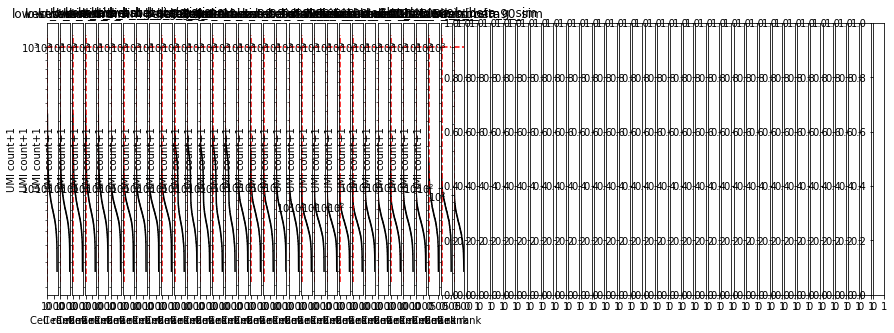

In [93]:
#Not filtering cells for now
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        #for subcluster in subcluster_names:
        subcluster = 'Keep All'
        annot_bcs = bcs
        #cf.append(np.isin(bcs,annot_bcs) & cf_)
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [94]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [95]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


(array([ 6.,  8., 11., 14., 23., 12.,  9., 10.,  3.,  4.]),
 array([0.06077131, 0.31767224, 0.57457317, 0.8314741 , 1.08837503,
        1.34527596, 1.60217689, 1.85907782, 2.11597874, 2.37287967,
        2.6297806 ]),
 <BarContainer object of 10 artists>)

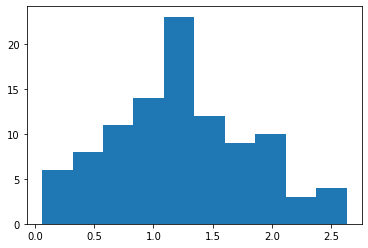

In [96]:
plt.hist((params[0,:,0]))

In [35]:
# k=3
# epochs=10

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1 created.
INFO:root:Dataset: lowest_b_sim_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:47 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k1 created.
INFO:root:Dataset: lowest_b_sim_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:47 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k2 created.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:47 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3 created.
INFO:root:Dataset: lowest_b_sim_k4
INFO:root:

/home/tchari/monod/src/monod/preprocess.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k5 created.
INFO:root:Dataset: lowest_beta100_sim_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:30 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k1 created.
INFO:root:Dataset: lowest_beta100_sim_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:30 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k2 created.
INFO:root:Dataset: lowest_beta100_sim_k3
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:30 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k3 created.
INFO:root:Dataset: lowest_beta100_sim_k4
INFO:ro

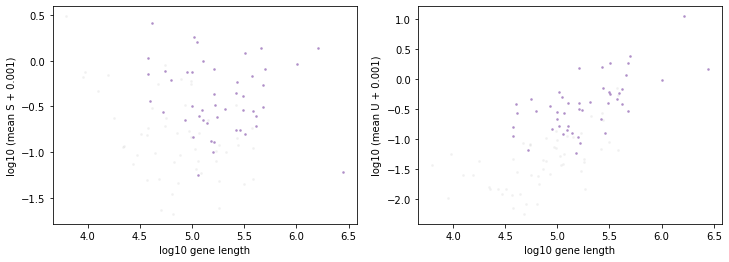

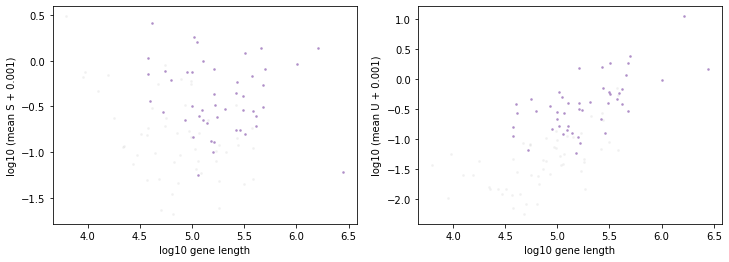

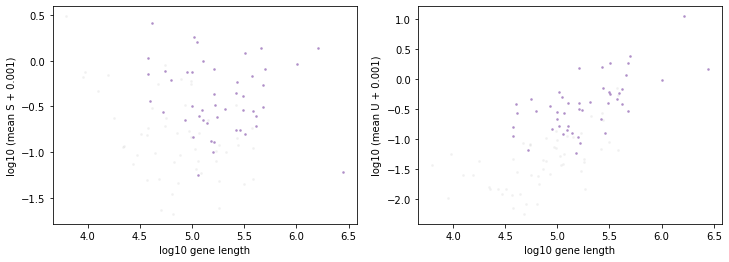

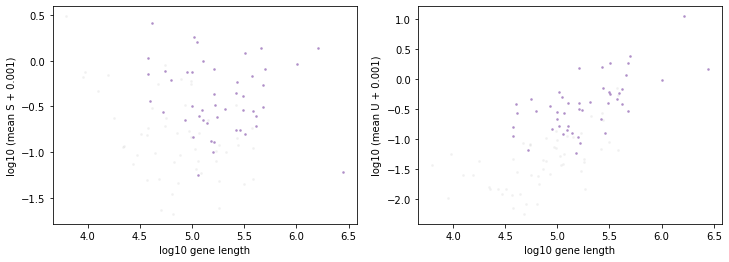

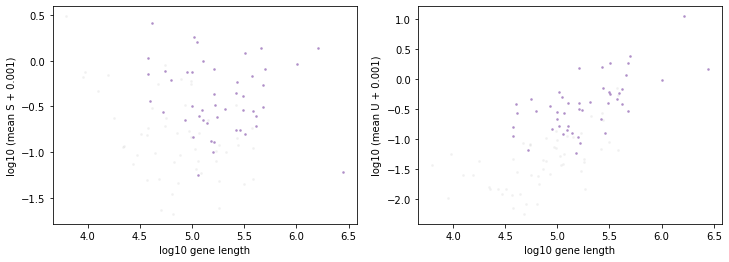

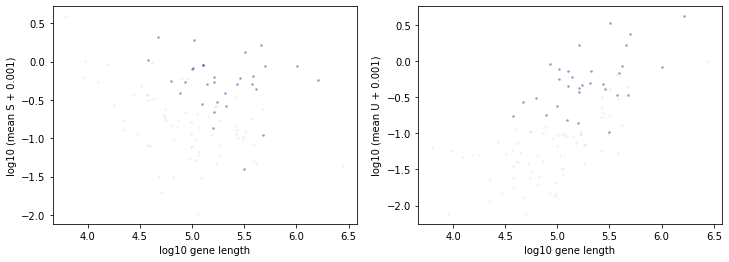

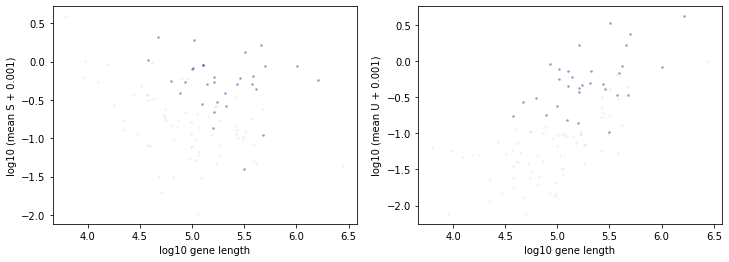

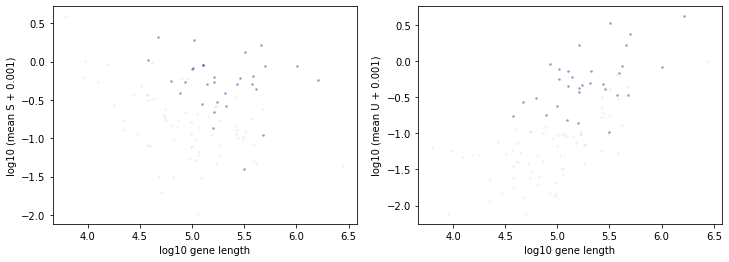

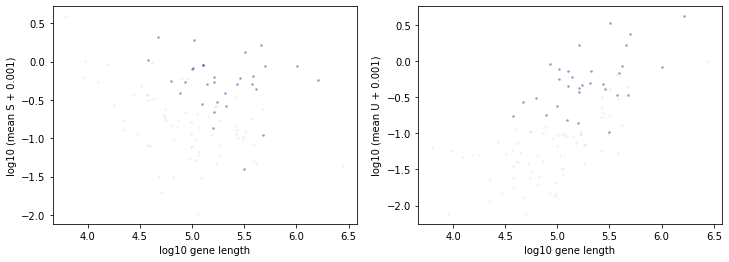

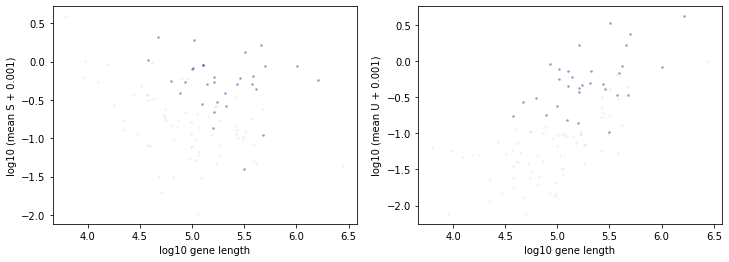

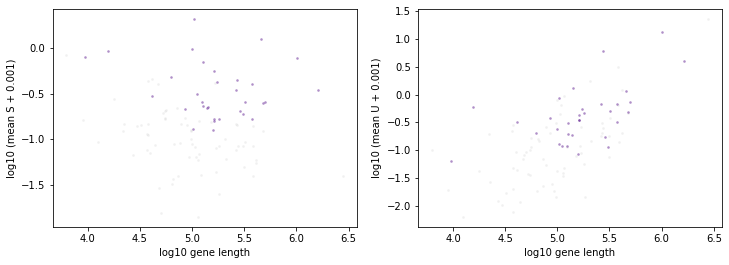

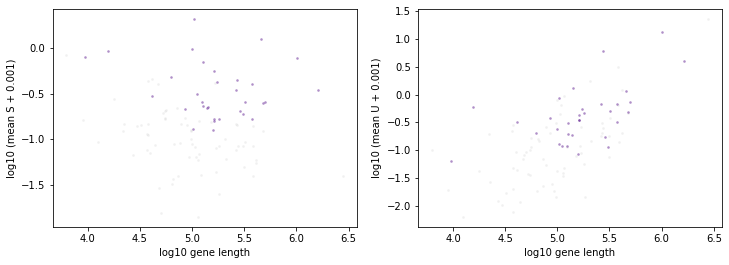

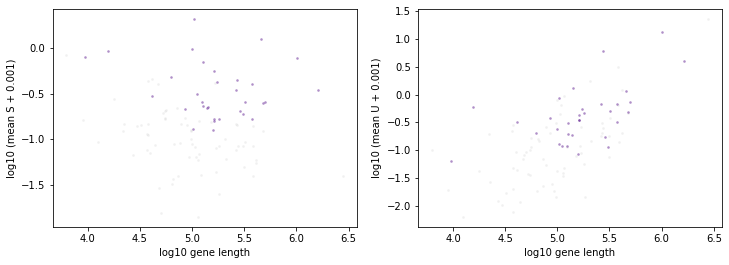

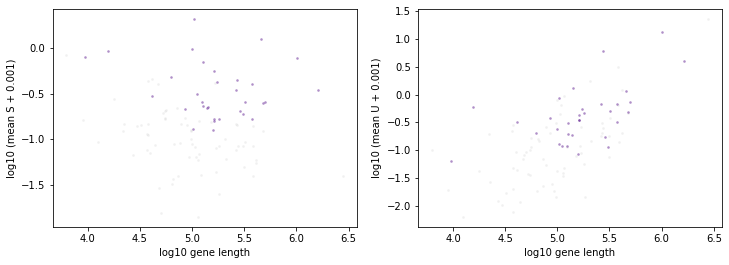

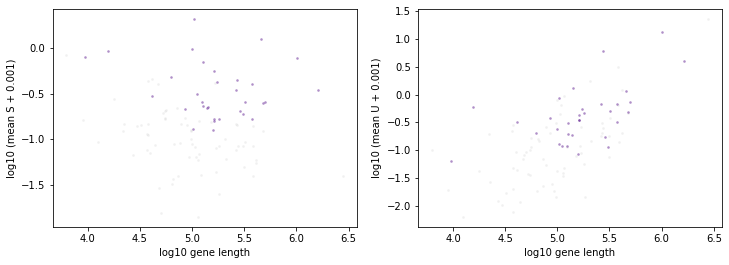

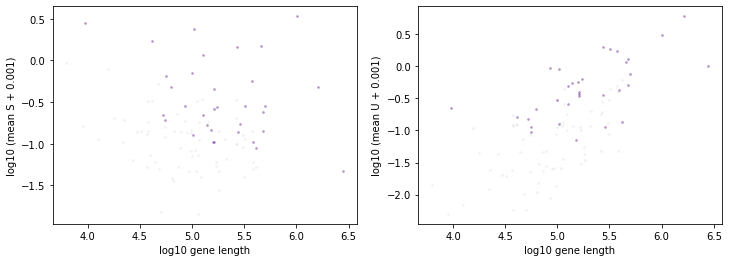

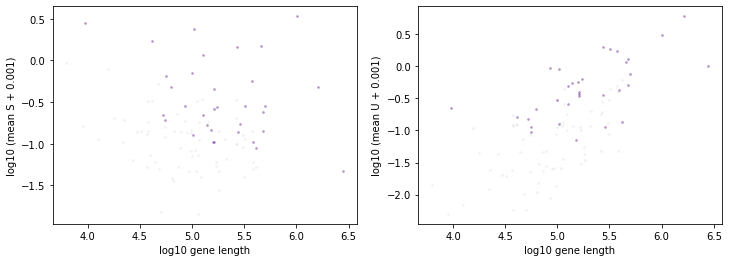

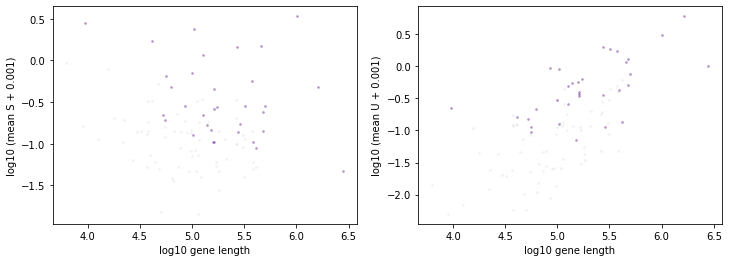

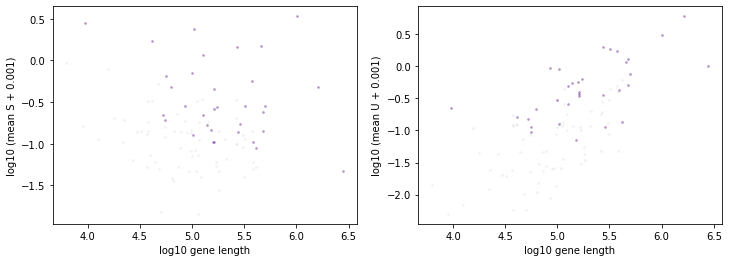

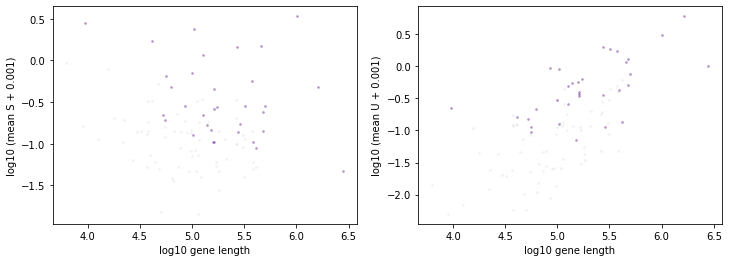

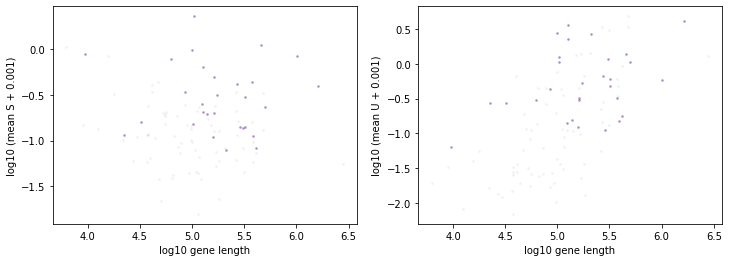

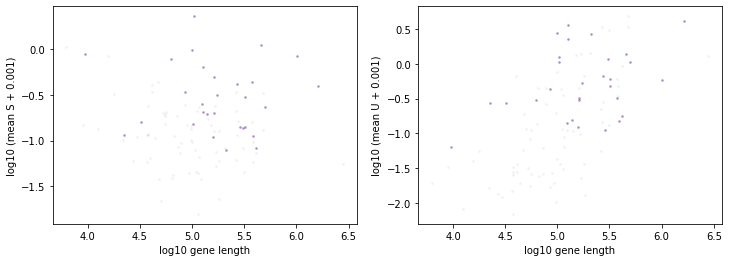

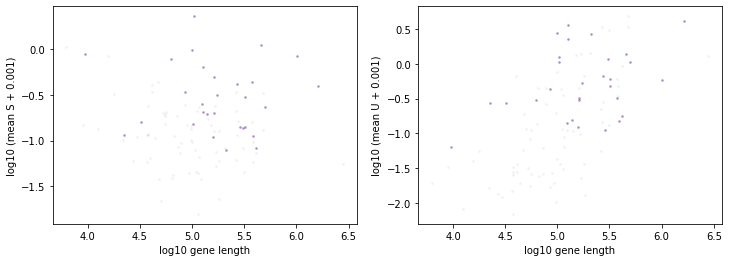

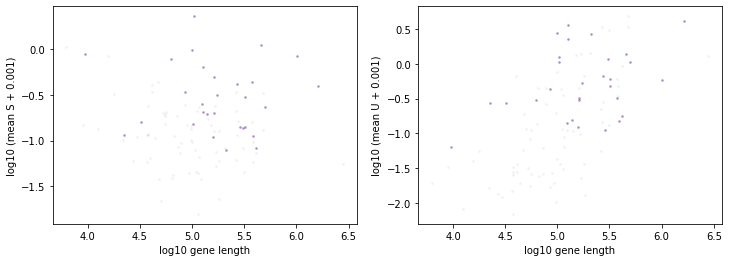

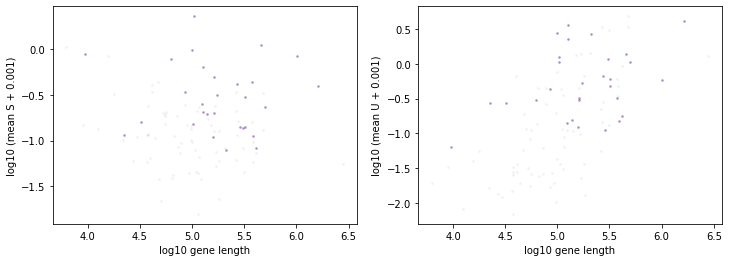

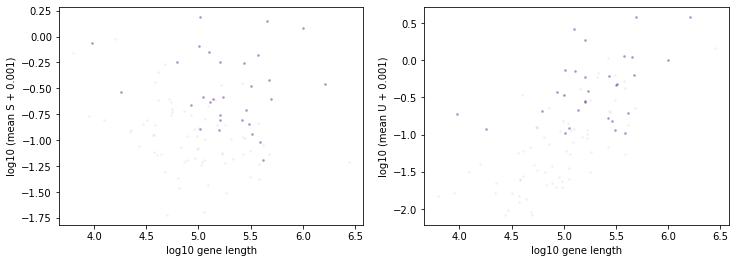

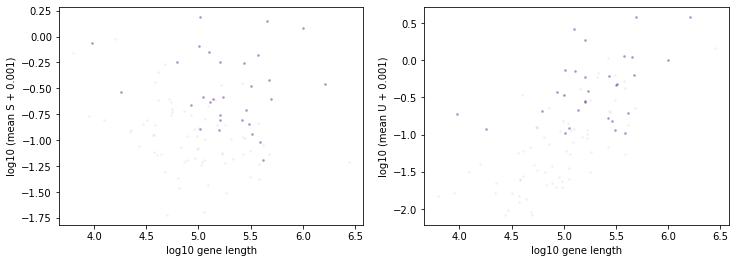

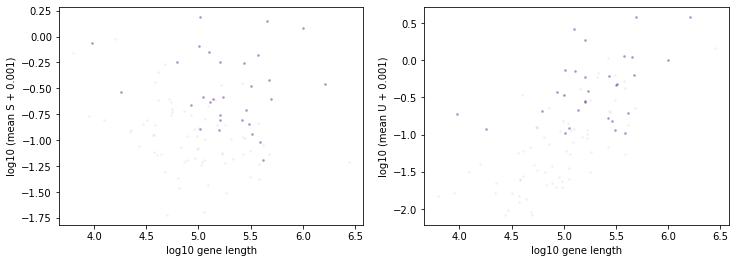

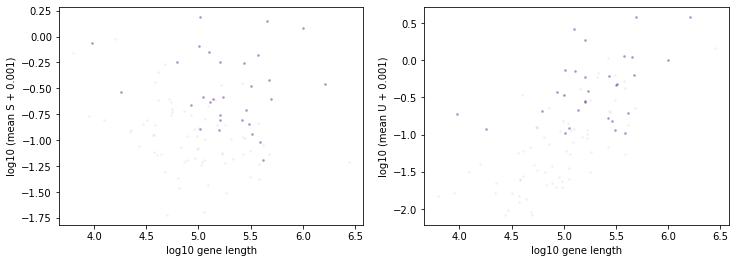

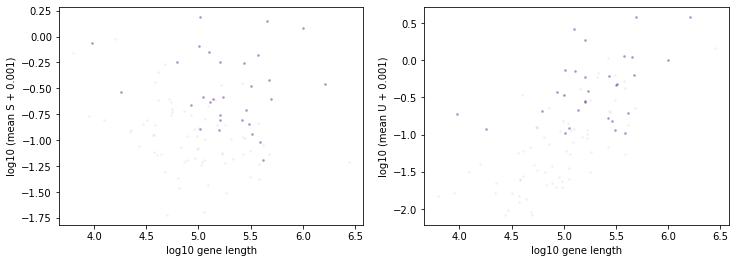

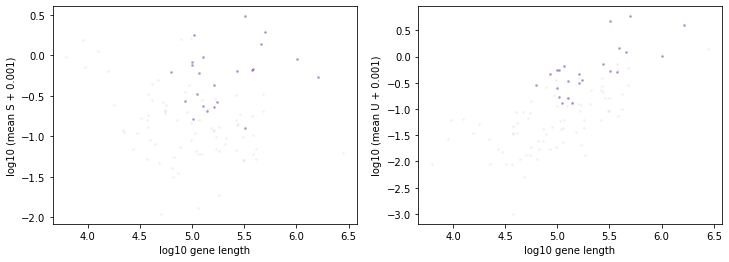

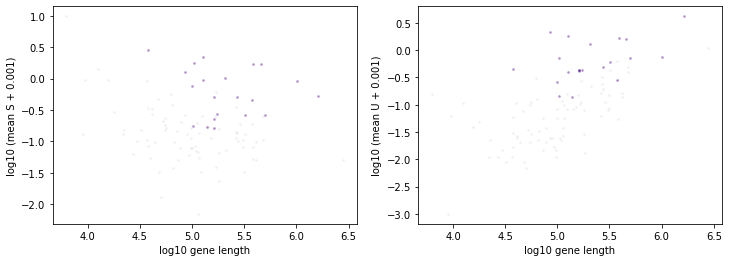

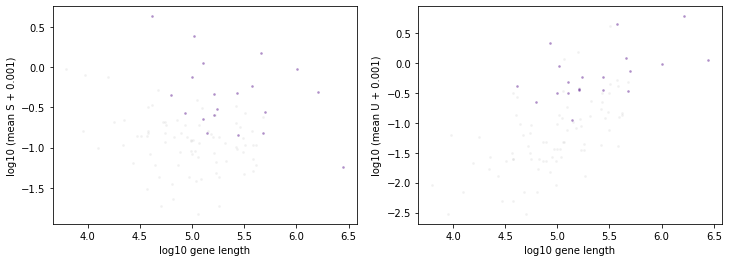

In [97]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='simTests_MM',batch_id=1,\
                                             datestring='230411', n_genes=100,exp_filter_threshold=None,cf=cf)

**Control test with standard Monod fit on first, known cluster of cells**

INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 2.9 seconds.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 2.9 seconds.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_beta90_sim_k1/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_beta90_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_beta90_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 2.8 seconds.


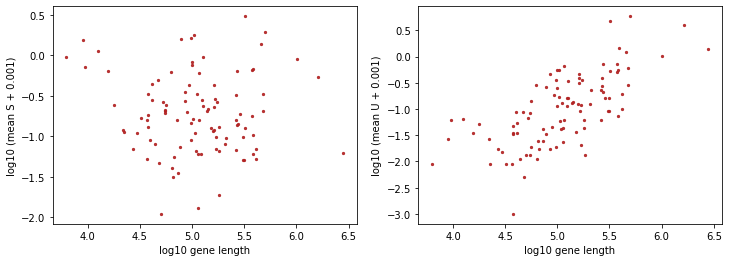

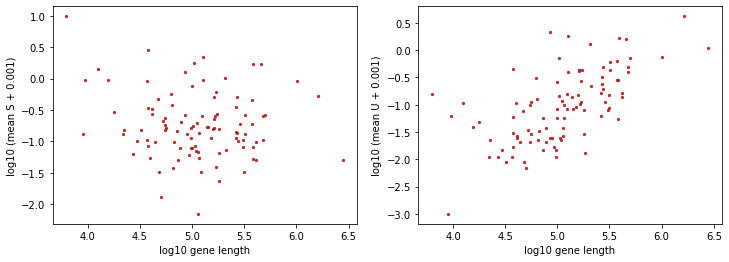

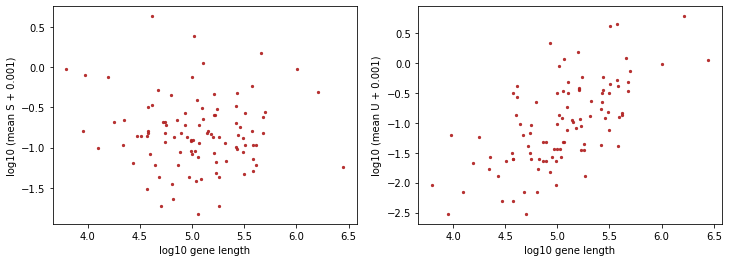

In [98]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(ks)-3,len(ks)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [99]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230411_025_simTests_MM_1/oneClus_lowest_beta90_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.


**Run Mixture Model on all cells**

In [100]:
epochs=10

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 

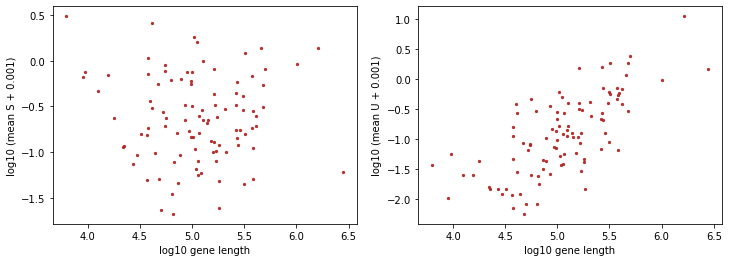

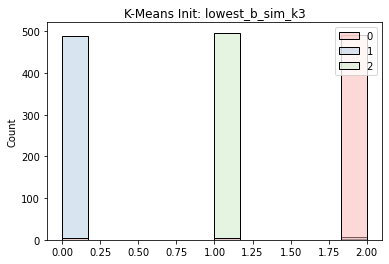

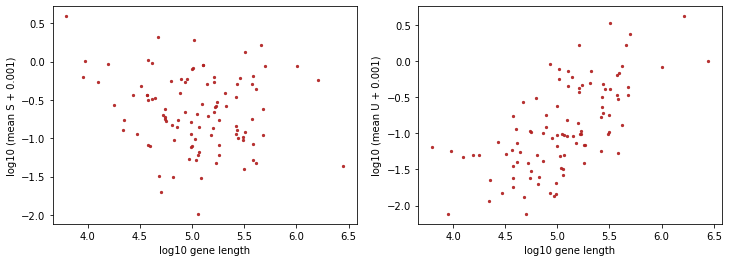

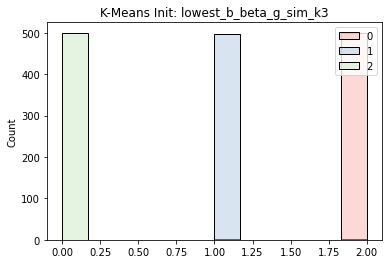

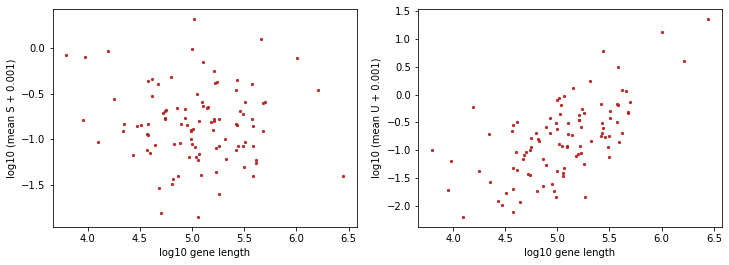

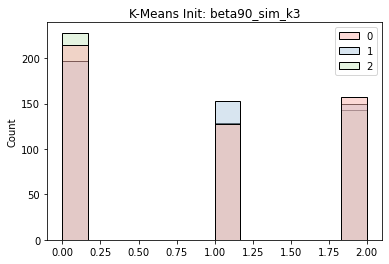

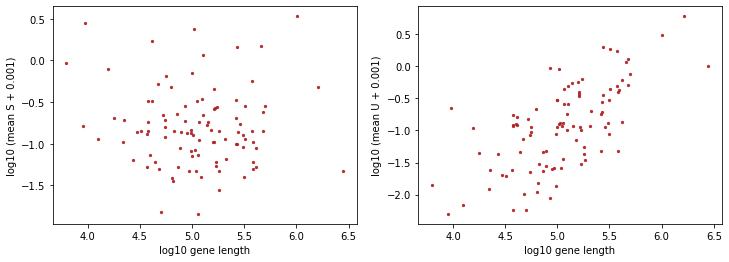

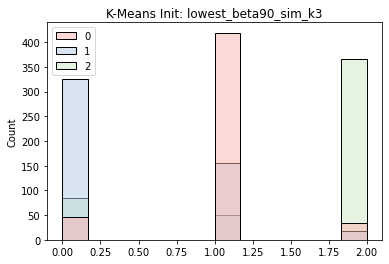

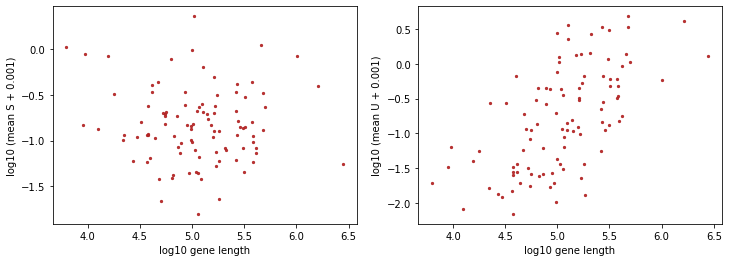

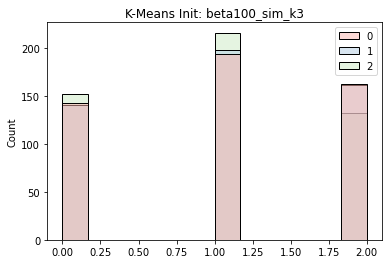

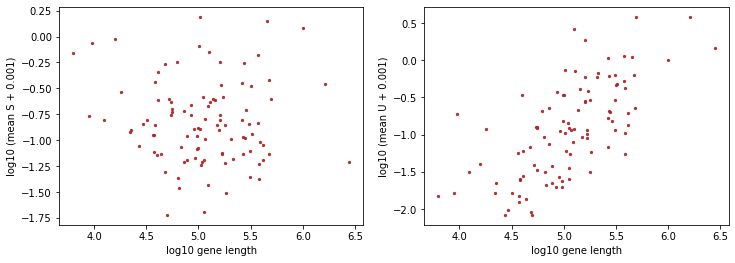

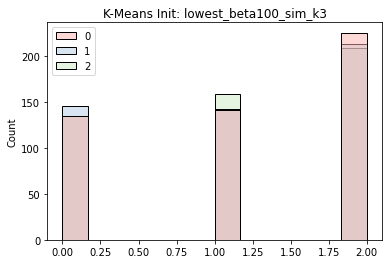

In [101]:
for i in range(2,len(ks)-3,5):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_

    labels = labs
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical([0]*500+[1]*500+[2]*500), kde=False,palette='Pastel1')
    plt.title('K-Means Init: '+dataset_names[i])

    
    

INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -178009.4659644133

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k2


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k2/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4651182 0.5348818]
Q Function:  -173170.11673928413

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38100725 0.61899275]
Q Function:  -173544.4814663729

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40423785 0.59576215]
Q Function:  -172988.85279124178

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36545042 0.63454958]
Q Function:  -173018.9077085101

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.43079365 0.56920635]
Q Function:  -174884.8039294355

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33865413 0.66134587]
Q Function:  -171141.786279455

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3964262 0.6035738]
Q Function:  -175062.63826179993

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39714034 0.60285966]
Q Function:  -174700.67481705104

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.49574715 0.50425285]
Q Function:  -174050.38813389873

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35081986 0.64918014]
Q Function:  -171707.9725698783

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.37651345 0.36803008 0.25545648]
Q Function:  -170856.40782702164

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34404139 0.34019528 0.31576333]
Q Function:  -169924.32006627275

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35525677 0.34434328 0.30039995]
Q Function:  -171298.0216030907

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33758071 0.34166616 0.32075313]
Q Function:  -173064.13497625577

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3360974  0.33624362 0.32765898]
Q Function:  -168536.58883849965

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33195456 0.33508294 0.33296249]
Q Function:  -168542.21518297255

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34665165 0.33825279 0.31509556]
Q Function:  -170533.41703606775

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33528501 0.33920706 0.32550793]
Q Function:  -173082.3048999908

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33598162 0.33615952 0.32785886]
Q Function:  -168537.3429852997

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33477197 0.33892426 0.32630376]
Q Function:  -170769.9718917367

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k4/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26336232 0.40110937 0.24977138 0.08575693]
Q Function:  -172225.04483116744

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32105648 0.33687207 0.34167755 0.0003939 ]
Q Function:  -169656.3488665281

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.22817712e-01 3.39490851e-01 3.37624526e-01 6.69120673e-05]
Q Function:  -169861.58114995816

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.10012975e-01 3.55780312e-01 3.34192699e-01 1.40138193e-05]
Q Function:  -170624.67708248628

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.15306209e-01 3.48361315e-01 3.36329580e-01 2.89571201e-06]
Q Function:  -170826.55852507282

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.27027489e-01 3.38896827e-01 3.34075229e-01 4.54759625e-07]
Q Function:  -168401.28448961466

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.27817246e-01 3.35620600e-01 3.36562064e-01 8.93713211e-08]
Q Function:  -170779.30363738787

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.10662037e-01 3.55981652e-01 3.33356294e-01 1.76694819e-08]
Q Function:  -170596.4145385919

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.16131936e-01 3.48857625e-01 3.35010433e-01 5.37812775e-09]
Q Function:  -170803.07529747463

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.27241978e-01 3.39213307e-01 3.33544714e-01 1.55337098e-09]
Q Function:  -168418.80248644116

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k5/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23039808 0.14058677 0.2914884  0.21336956 0.12415719]
Q Function:  -171105.12035396727

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2947604  0.220525   0.33382779 0.11811684 0.03276996]
Q Function:  -168421.8169589716

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29710116 0.21108929 0.34727493 0.1228423  0.02169232]
Q Function:  -173196.37289967688

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23758061 0.19282055 0.38250631 0.14592123 0.04117131]
Q Function:  -172160.74571336244

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30644945e-01 1.42626245e-01 3.30430417e-01 1.96223366e-01
 7.50270236e-05]
Q Function:  -170513.2921415222

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.14926177e-01 1.75044242e-01 3.44850214e-01 1.65179192e-01
 1.74642155e-07]
Q Function:  -169934.94402238817

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.18374496e-01 7.51960048e-02 3.43014698e-01 2.63414801e-01
 9.37461995e-10]
Q Function:  -170228.9619305827

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.01395417e-01 4.46877537e-02 3.61889068e-01 2.92027761e-01
 6.68868346e-10]
Q Function:  -170587.04252385176

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.09662885e-01 3.39395444e-02 3.51315961e-01 3.05081610e-01
 6.67659830e-10]
Q Function:  -169598.03488333325

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30208856e-01 2.87588228e-02 3.28628457e-01 3.12403863e-01
 6.67307280e-10]
Q Function:  -169663.6508932794

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:S

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -171829.51784313517

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k2/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32358881 0.67641119]
Q Function:  -168031.7310815197

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32735723 0.67264277]
Q Function:  -166945.9819327131

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31342601 0.68657399]
Q Function:  -168351.65654949844

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32686553 0.67313447]
Q Function:  -165850.53616234884

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31168711 0.68831289]
Q Function:  -168349.77965035668

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32646039 0.67353961]
Q Function:  -166884.39106043515

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31965864 0.68034136]
Q Function:  -166950.17636972747

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32080166 0.67919834]
Q Function:  -167565.62271929678

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31321597 0.68678403]
Q Function:  -167864.18715934776

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32414779 0.67585221]
Q Function:  -167282.5190312834

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31454661 0.33815035 0.34730304]
Q Function:  -165186.59836205927

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32326851 0.33385671 0.34287478]
Q Function:  -163295.87101052102

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32576364 0.33375232 0.34048405]
Q Function:  -164410.3607047579

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32098249 0.3346473  0.34437021]
Q Function:  -164126.3389447941

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32938875 0.33351517 0.33709608]
Q Function:  -163577.86583452515

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32225789 0.33468742 0.34305469]
Q Function:  -164136.22745274514

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33001824 0.33347235 0.33650941]
Q Function:  -163498.8449847988

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32316079 0.33455408 0.34228512]
Q Function:  -164134.6131244548

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31455404 0.33443335 0.35101261]
Q Function:  -164566.25721093707

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32887446 0.33345602 0.33766952]
Q Function:  -162164.03204306398

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k4/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36694268 0.18264015 0.30725013 0.14316704]
Q Function:  -166717.08647181574

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33954946 0.18373079 0.32884786 0.14787188]
Q Function:  -163910.05532301022

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34704452 0.18023056 0.31825332 0.1544716 ]
Q Function:  -164489.468221435

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33857672 0.18047988 0.32841985 0.15252355]
Q Function:  -161955.84819961712

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34952642 0.20192533 0.316987   0.13156124]
Q Function:  -165786.65334849758

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33773646 0.20813838 0.32847799 0.12564717]
Q Function:  -162958.0802147963

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3488366  0.0498598  0.31775016 0.28355344]
Q Function:  -165746.54861242927

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33966005 0.00794776 0.32740804 0.32498414]
Q Function:  -163964.2988254538

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35173044 0.0033569  0.31556178 0.32935088]
Q Function:  -165631.5114133529

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33811426 0.00051255 0.32835998 0.33301321]
Q Function:  -162922.2139763437

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k5/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24723613 0.16577681 0.28819974 0.20928312 0.08950421]
Q Function:  -167789.67561028362

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00645857 0.35506149 0.32925438 0.18035689 0.12886867]
Q Function:  -166048.86759506995

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.91123223e-07 3.35581226e-01 3.32847272e-01 1.52868373e-01
 1.78702838e-01]
Q Function:  -163407.823169286

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.11243506e-09 3.44620136e-01 3.34413889e-01 1.19629504e-01
 2.01336468e-01]
Q Function:  -165098.05319754253

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66684150e-10 3.34155419e-01 3.33209910e-01 1.63250048e-01
 1.69384624e-01]
Q Function:  -163411.6325542725

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66705450e-10 3.42719116e-01 3.34676255e-01 8.47290660e-02
 2.37875562e-01]
Q Function:  -164689.3245494165

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66745601e-10 3.34794887e-01 3.33191012e-01 7.35933115e-02
 2.58420789e-01]
Q Function:  -163184.43294833353

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66688846e-10 3.35094897e-01 3.33653779e-01 5.21140181e-02
 2.79137306e-01]
Q Function:  -164387.88465146918

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66735317e-10 3.38731337e-01 3.34876941e-01 9.01682374e-03
 3.17374897e-01]
Q Function:  -163369.83801949135

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66671009e-10 3.50099999e-01 3.33716013e-01 1.32663502e-03
 3.14857352e-01]
Q Function:  -164715.8834214185

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -169926.37995451438

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k2/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.45439119 0.54560881]
Q Function:  -170396.6864202144

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34982431 0.65017569]
Q Function:  -169725.64175048203

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.62290887 0.37709113]
Q Function:  -164620.3276764832

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666666 0.33333334]
Q Function:  -159636.26061629734

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -161595.11243983117

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -161595.11243983117

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -161595.11243983117

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -161595.11243983117

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -161595.11243983117

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -161595.11243983117

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.37115673 0.32674854 0.30209472]
Q Function:  -170487.65148928628

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35367955 0.33370822 0.31261223]
Q Function:  -163651.1298872126

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29241033 0.33333333 0.37425634]
Q Function:  -162009.92811146367

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27325083 0.33333333 0.39341584]
Q Function:  -161648.56653758715

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30912428 0.33333333 0.35754239]
Q Function:  -160082.03652668846

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32854951 0.33333333 0.33811715]
Q Function:  -160798.28739773406

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33295062 0.33333333 0.33371604]
Q Function:  -164279.1499238188

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33457523 0.33333333 0.33209144]
Q Function:  -161360.49800078862

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33446705 0.33333333 0.33219961]
Q Function:  -159874.74338060254

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33446693 0.33333333 0.33219974]
Q Function:  -159874.74344444374

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k4/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32810084 0.012806   0.30984778 0.34924538]
Q Function:  -171072.21732892923

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38426473 0.00093659 0.25839356 0.35640512]
Q Function:  -164620.58465119987

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.37086613e-01 6.66666665e-10 3.29580053e-01 3.33333333e-01]
Q Function:  -156966.55337730734

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33492425e-01 6.66666665e-10 3.33174241e-01 3.33333333e-01]
Q Function:  -158880.78108442156

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33358413e-01 6.66666665e-10 3.33308253e-01 3.33333333e-01]
Q Function:  -160307.44296761585

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33358393e-01 6.66666665e-10 3.33308273e-01 3.33333333e-01]
Q Function:  -160307.4427920848

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33358393e-01 6.66666665e-10 3.33308273e-01 3.33333333e-01]
Q Function:  -160307.44279207045

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33358393e-01 6.66666665e-10 3.33308273e-01 3.33333333e-01]
Q Function:  -160307.44279207045

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33358393e-01 6.66666665e-10 3.33308273e-01 3.33333333e-01]
Q Function:  -160307.44279207045

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33358393e-01 6.66666665e-10 3.33308273e-01 3.33333333e-01]
Q Function:  -160307.44279207045

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k5/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta90_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.19929095 0.23000183 0.20157891 0.16289823 0.20623008]
Q Function:  -170753.4374878418

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.22952302 0.33034096 0.04268818 0.08158743 0.31586041]
Q Function:  -163165.9142376111

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0618196  0.33548502 0.11322297 0.269362   0.22011041]
Q Function:  -159782.8803352756

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24696097 0.33483462 0.00147    0.08487108 0.33186334]
Q Function:  -161710.9051857413

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.61195812e-01 3.37807878e-01 6.66666664e-10 1.67662976e-01
 3.33333333e-01]
Q Function:  -163697.27127141278

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.54887404e-02 3.52278222e-01 6.66666664e-10 2.48899704e-01
 3.33333333e-01]
Q Function:  -166096.3144280876

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.14828573e-01 3.48410495e-01 6.66666664e-10 1.03427598e-01
 3.33333333e-01]
Q Function:  -163708.62171908893

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.94488234e-01 3.74520571e-01 6.66666664e-10 9.76578617e-02
 3.33333333e-01]
Q Function:  -166466.60101827775

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.82490086e-01 3.49727106e-01 6.66666664e-10 3.44494745e-02
 3.33333333e-01]
Q Function:  -160630.62569995044

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.24832802e-01 3.54886184e-01 6.66666664e-10 1.86947680e-01
 3.33333333e-01]
Q Function:  -163564.11064105848

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k1/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161330.97311945417

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k2/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.6483326 0.3516674]
Q Function:  -157426.61610623336

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.63053523 0.36946477]
Q Function:  -156858.7659704487

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.67770655 0.32229345]
Q Function:  -155431.53709372794

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914675 0.34085325]
Q Function:  -158344.3227157399

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68761972 0.31238028]
Q Function:  -156238.66963408625

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66129747 0.33870253]
Q Function:  -158317.32885693538

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68923579 0.31076421]
Q Function:  -156347.4216890178

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65835448 0.34164552]
Q Function:  -157574.50857863753

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.6850793 0.3149207]
Q Function:  -157965.34265574662

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65743062 0.34256938]
Q Function:  -157576.42056567385

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24363566 0.41635749 0.34000685]
Q Function:  -155520.82671860384

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34263468 0.34055543 0.31680989]
Q Function:  -155565.9542677987

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3264966  0.32569904 0.34780436]
Q Function:  -155698.7384686462

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35283922 0.30811921 0.33904157]
Q Function:  -155502.03187251286

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33679333 0.33249286 0.3307138 ]
Q Function:  -155218.66971328197

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32020049 0.32059232 0.3592072 ]
Q Function:  -155685.35968952317

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34426463 0.32797734 0.32775803]
Q Function:  -154850.6581509953

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33831416 0.33208121 0.32960463]
Q Function:  -155992.47570644796

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34410205 0.31386809 0.34202986]
Q Function:  -154207.48802408815

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34647323 0.33137676 0.32215001]
Q Function:  -156879.1618740181

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k4/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23881855 0.34093854 0.20549046 0.21475245]
Q Function:  -156572.42281254003

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32503198 0.32457521 0.05841354 0.29197926]
Q Function:  -154151.43291946725

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33150642 0.33002686 0.01417922 0.3242875 ]
Q Function:  -155237.47328318935

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31707056 0.35928816 0.00696947 0.31667181]
Q Function:  -155665.00118825803

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3434214  0.32792987 0.00429698 0.32435175]
Q Function:  -154842.67544215726

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.39800129e-01 3.29646530e-01 1.66279139e-04 3.30387062e-01]
Q Function:  -156024.8090495495

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.46513239e-01 3.41192065e-01 5.68720131e-08 3.12294639e-01]
Q Function:  -154248.47277630327

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.44676132e-01 3.22495873e-01 7.20066396e-10 3.32827994e-01]
Q Function:  -156215.07266778534

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.27535903e-01 3.51080594e-01 6.69551205e-10 3.21383502e-01]
Q Function:  -155824.80605097767

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.22420647e-01 3.62219687e-01 6.66846537e-10 3.15359666e-01]
Q Function:  -156370.9179439156

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k5


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k5/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04361433 0.21147891 0.31933933 0.31377498 0.11179245]
Q Function:  -156511.95611399453

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00536965 0.18877109 0.31947529 0.32854599 0.15783799]
Q Function:  -155562.925184889

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.22308800e-09 1.35269389e-01 3.43618919e-01 3.16569872e-01
 2.04541817e-01]
Q Function:  -154446.26209253626

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66671061e-10 1.07428732e-01 3.40894968e-01 3.29480005e-01
 2.22196294e-01]
Q Function:  -156944.54032281082

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667092e-10 7.95880586e-02 3.47834855e-01 3.30484373e-01
 2.42092714e-01]
Q Function:  -155022.5626089864

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666944e-10 6.84611969e-02 3.37420302e-01 3.32231336e-01
 2.61887165e-01]
Q Function:  -155998.53317739983

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666685e-10 8.08990105e-02 4.41430765e-01 3.26823221e-01
 1.50847003e-01]
Q Function:  -159841.77591877812

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667557e-10 6.50276266e-02 3.59121281e-01 3.29432426e-01
 2.46418665e-01]
Q Function:  -155841.40066355513

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666686e-10 7.76373929e-02 3.71359001e-01 3.15334112e-01
 2.35669494e-01]
Q Function:  -155812.45828151432

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667503e-10 1.80338937e-01 3.60896352e-01 3.37645277e-01
 1.21119434e-01]
Q Function:  -157782.3919263344

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.



/home/tchari/monod/src/monod/extract_data.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -181304.9780381506

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k2/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.58807704 0.41192296]
Q Function:  -182203.32795824675

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.57890931 0.42109069]
Q Function:  -180983.5996000048

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36855092 0.63144908]
Q Function:  -175768.0670399482

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33335591 0.66664409]
Q Function:  -173918.79247852048

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33330126 0.66669874]
Q Function:  -181858.2637550912

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33330125 0.66669875]
Q Function:  -181858.26378885575

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33330125 0.66669875]
Q Function:  -181858.26378886192

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33330125 0.66669875]
Q Function:  -181858.26378886192

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33330125 0.66669875]
Q Function:  -181858.26378886192

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33330125 0.66669875]
Q Function:  -181858.26378886192

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35737154 0.40306049 0.23956797]
Q Function:  -182064.3484097761

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1477896  0.36180291 0.49040749]
Q Function:  -179594.7176639564

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.22982947 0.10965335 0.66051719]
Q Function:  -173213.20502185624

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01963751 0.31482879 0.6655337 ]
Q Function:  -172301.65082353406

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01849312 0.3147984  0.66670848]
Q Function:  -181804.9865761908

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.55167688e-06 3.33303248e-01 6.66694200e-01]
Q Function:  -181893.36143038224

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.25538702e-10 3.33301249e-01 6.66698751e-01]
Q Function:  -181858.26761775967

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66718065e-10 3.33301248e-01 6.66698751e-01]
Q Function:  -181858.2637901018

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66708177e-10 3.33301248e-01 6.66698751e-01]
Q Function:  -181858.26378986347

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66708176e-10 3.33301248e-01 6.66698751e-01]
Q Function:  -181858.26378986344

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k4/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21059483 0.25555178 0.38615929 0.1476941 ]
Q Function:  -178270.78769056016

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.25985717 0.13777346 0.261121   0.34124837]
Q Function:  -175651.56088302663

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.19318638 0.14229401 0.33266817 0.33185143]
Q Function:  -162538.49497879058

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.14217273 0.19116058 0.33333335 0.33333333]
Q Function:  -169255.7843128138

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03260584 0.3007275  0.33333333 0.33333333]
Q Function:  -166983.48699075333

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09811782 0.23521551 0.33333333 0.33333333]
Q Function:  -175074.38597892557

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.07318523 0.26012106 0.33336014 0.33333357]
Q Function:  -181069.56970134625

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.22298492 0.11034841 0.33333333 0.33333333]
Q Function:  -172206.26576620675

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01082018 0.32251315 0.33333333 0.33333333]
Q Function:  -165745.96584976016

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00291526 0.33041807 0.33333333 0.33333333]
Q Function:  -173675.99246079772

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k5/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/beta100_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.43431753 0.20707576 0.09385543 0.20014966 0.06460161]
Q Function:  -178715.76680765094

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38675452 0.13356098 0.03693355 0.34294059 0.09981036]
Q Function:  -174925.6426944405

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26911409 0.29074049 0.0062057  0.33333333 0.10060638]
Q Function:  -167660.8144045624

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.11072883e-01 3.32720482e-01 6.47364329e-08 3.33333318e-01
 2.28732521e-02]
Q Function:  -178709.08262209417

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.19396189e-01 3.33333333e-01 6.66666665e-10 3.33333333e-01
 1.39371442e-02]
Q Function:  -174749.1022534719

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32049297e-01 3.33333333e-01 6.66666664e-10 3.33333333e-01
 1.28403653e-03]
Q Function:  -174941.68736658292

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 3.33333333e-01
 6.66666664e-10]
Q Function:  -173723.83061510616

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 3.33333333e-01
 6.66666664e-10]
Q Function:  -173721.58252170228

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 3.33333333e-01
 6.66666664e-10]
Q Function:  -173721.58252170228

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 3.33333333e-01
 6.66666664e-10]
Q Function:  -173721.58252170228

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k1


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -156426.50380954635

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k2/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.63430514 0.36569486]
Q Function:  -157314.52633315403

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.95232649 0.04767351]
Q Function:  -157540.35255803991

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.97288194 0.02711806]
Q Function:  -156380.92496255267

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.98503193 0.01496807]
Q Function:  -156411.5847903994

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.99858387 0.00141613]
Q Function:  -156438.0282285193

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99849538e-01 1.50462464e-04]
Q Function:  -156428.61495272943

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99985604e-01 1.43958253e-05]
Q Function:  -156426.81907083635

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99998600e-01 1.40011553e-06]
Q Function:  -156426.53902924576

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999863e-01 1.36984693e-07]
Q Function:  -156426.5077134398

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999986e-01 1.40057670e-08]
Q Function:  -156426.5042380307

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.69090087 0.02689627 0.28220286]
Q Function:  -155825.16490341187

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.60639387 0.0023571  0.39124902]
Q Function:  -156061.2590850601

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54211317 0.00066643 0.4572204 ]
Q Function:  -155472.95992134098

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.74099837e-01 6.66666756e-10 5.25900162e-01]
Q Function:  -154017.3193822922

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.13237008e-01 6.66666665e-10 4.86762991e-01]
Q Function:  -155067.8727589447

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.46445034e-01 6.66666665e-10 4.53554965e-01]
Q Function:  -154947.2303674792

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.21648753e-01 6.66666665e-10 4.78351246e-01]
Q Function:  -153799.5525934249

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.78499501e-01 6.66666665e-10 4.21500498e-01]
Q Function:  -154925.45499608794

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.29393315e-01 6.66666665e-10 3.70606685e-01]
Q Function:  -154710.05565985746

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.54885470e-01 6.66666665e-10 3.45114530e-01]
Q Function:  -153213.54493195715

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k4/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.


INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21909663 0.33189179 0.20455958 0.24445201]
Q Function:  -155911.82198422303

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09532329 0.28518505 0.21398527 0.4055064 ]
Q Function:  -155614.67500562518

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.14226872 0.28806595 0.24199943 0.3276659 ]
Q Function:  -153163.8210884877

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2226214  0.24765162 0.20961259 0.32011439]
Q Function:  -151465.92416471842

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.17477023 0.23859086 0.25829157 0.32834735]
Q Function:  -150856.58280542304

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21402497 0.32610034 0.15401723 0.30585747]
Q Function:  -152085.53441911584

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21616014 0.33817023 0.13823433 0.30743529]
Q Function:  -152415.23853969513

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24049228 0.33039468 0.10154003 0.32757301]
Q Function:  -149961.10552683118

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.19271779 0.31998087 0.14516999 0.34213135]
Q Function:  -154171.56942790924

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.20347116 0.35017613 0.13455828 0.31179442]
Q Function:  -153332.66614283453

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k5/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta100_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23948801 0.10987765 0.27636438 0.21243921 0.16183075]
Q Function:  -155545.3370447397

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24427271 0.10531874 0.29630117 0.1703206  0.18378679]
Q Function:  -155667.55096082922

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33358382 0.10222236 0.30179211 0.23437941 0.0280223 ]
Q Function:  -152855.03013590057

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32881381 0.03804287 0.32065833 0.30660243 0.00588256]
Q Function:  -152256.62286149926

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31840779e-01 1.02104268e-07 3.37107479e-01 3.31051639e-01
 6.66696515e-10]
Q Function:  -150814.3660776894

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.19891978e-01 9.72331383e-10 3.27590745e-01 3.52517275e-01
 6.66666665e-10]
Q Function:  -153862.6977130884

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.83575117e-01 6.67881400e-10 3.21757443e-01 3.94667439e-01
 6.66666664e-10]
Q Function:  -152264.45823991793

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34270887e-01 6.66666734e-10 3.16735725e-01 3.48993386e-01
 6.66666665e-10]
Q Function:  -150215.44484459964

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.26686056e-01 6.68817313e-10 3.20017693e-01 3.53296250e-01
 6.66666664e-10]
Q Function:  -149759.8602004507

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.15811317e-01 6.68402300e-10 3.19265352e-01 3.64923330e-01
 6.66666665e-10]
Q Function:  -153885.8859733455

INFO:root:Non-parallelized grid scan complete.


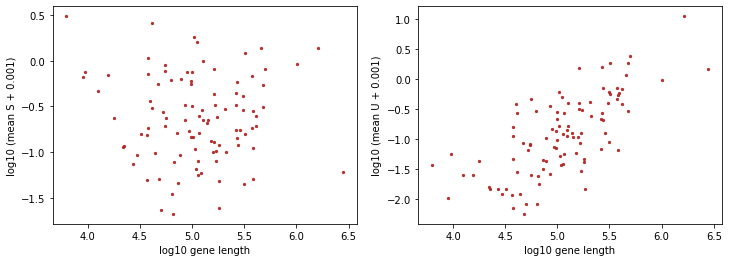

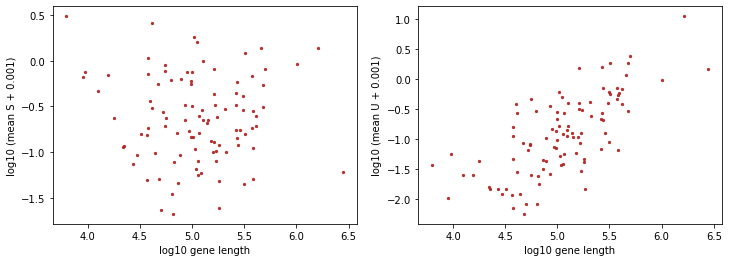

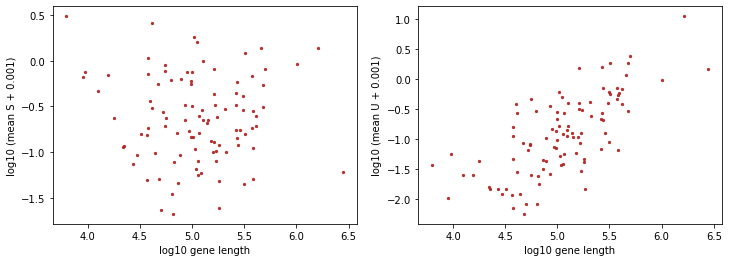

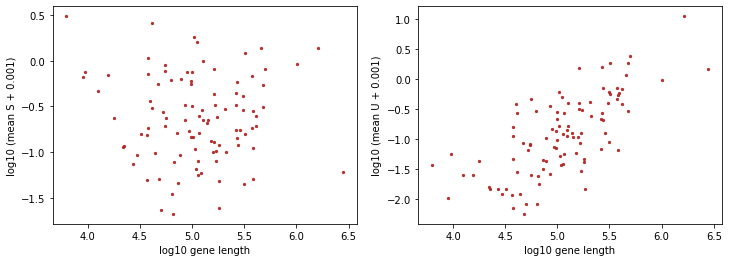

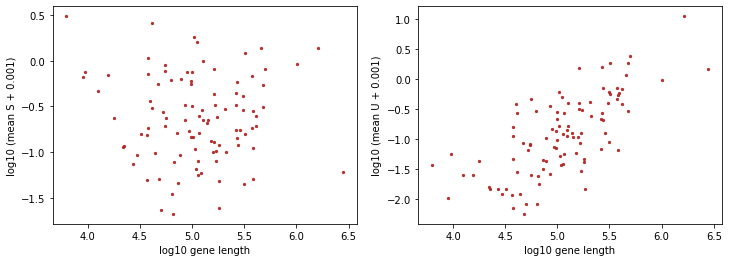

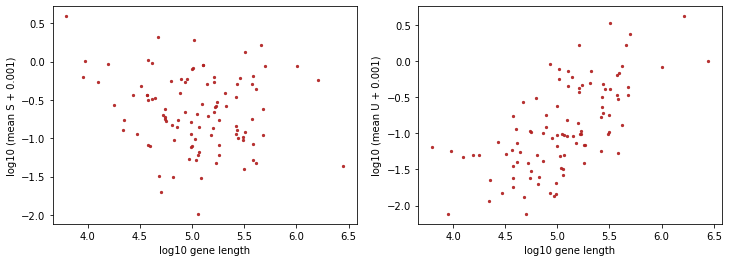

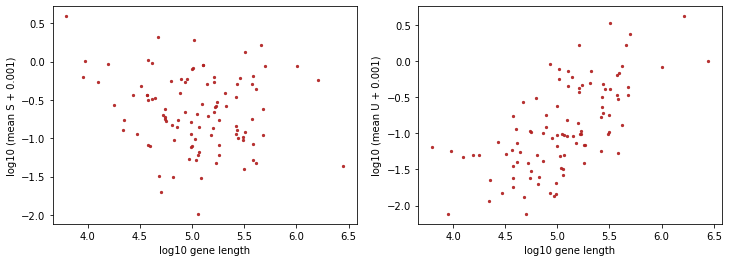

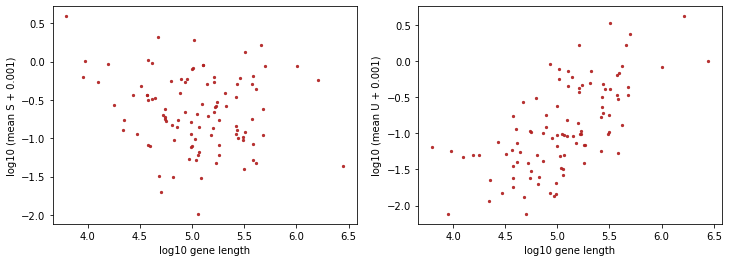

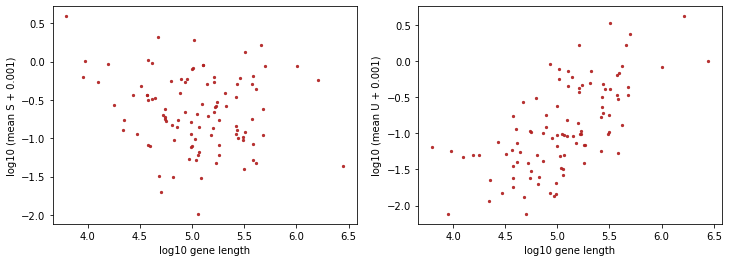

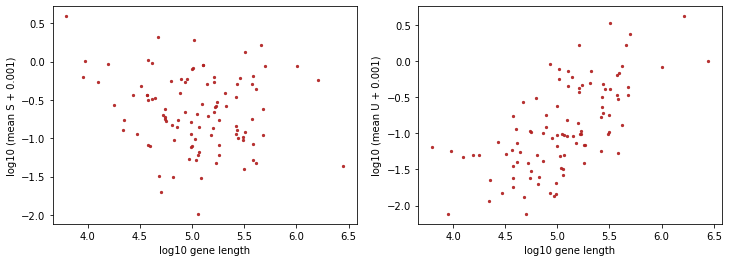

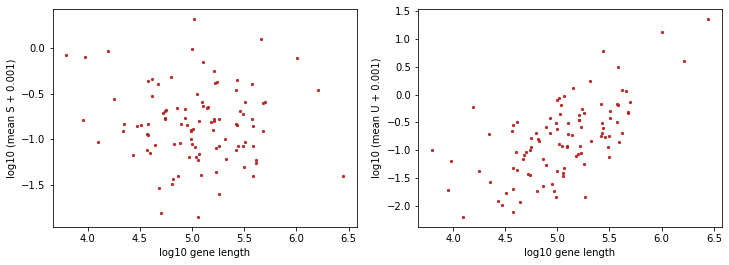

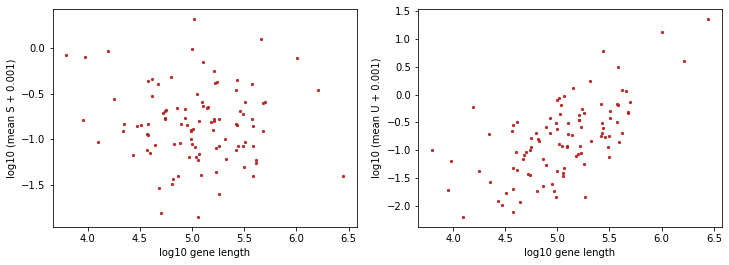

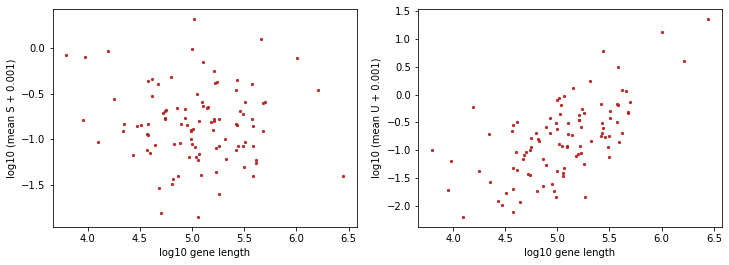

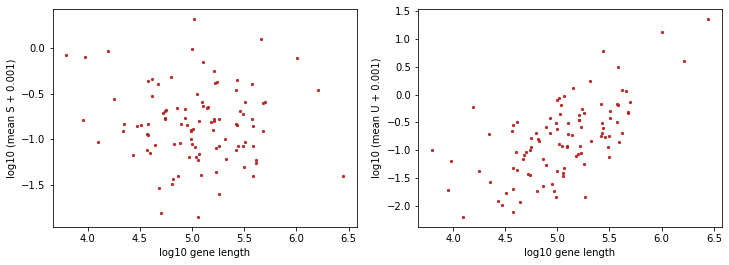

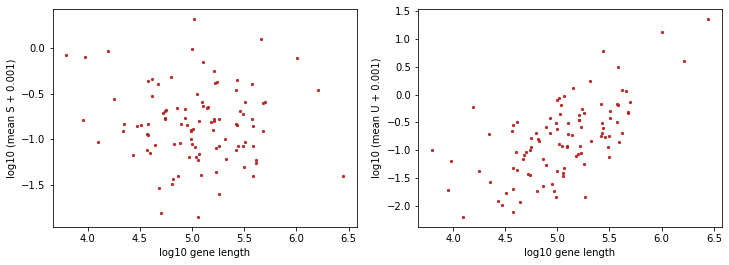

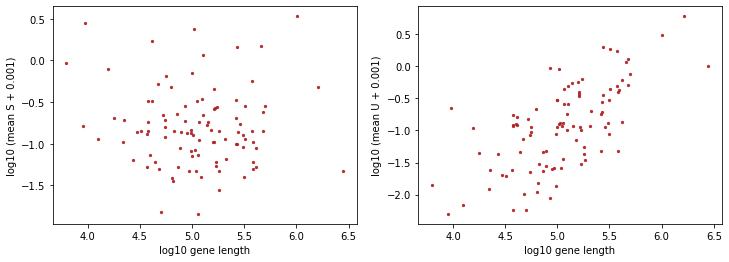

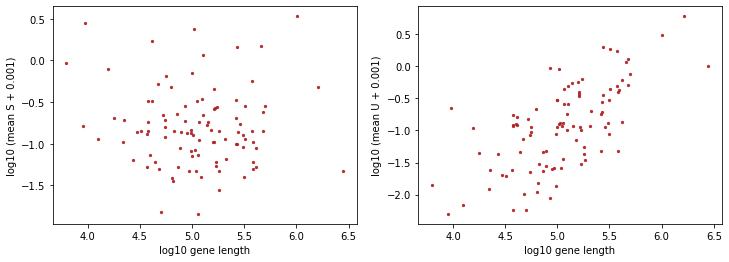

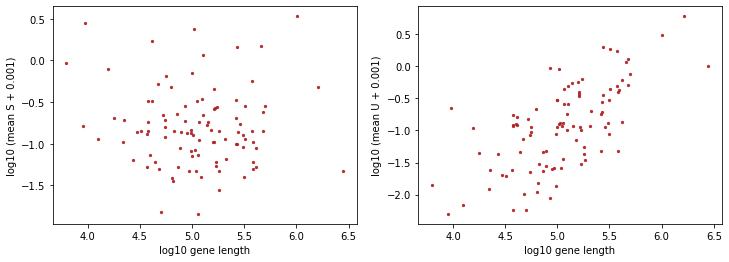

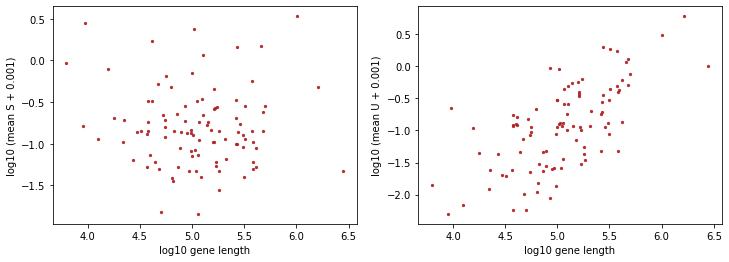

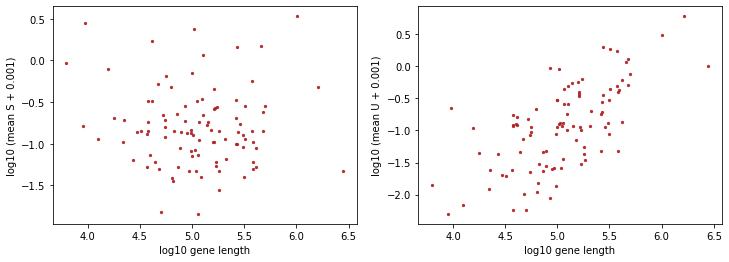

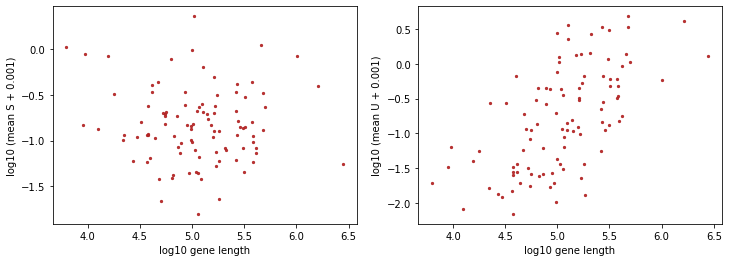

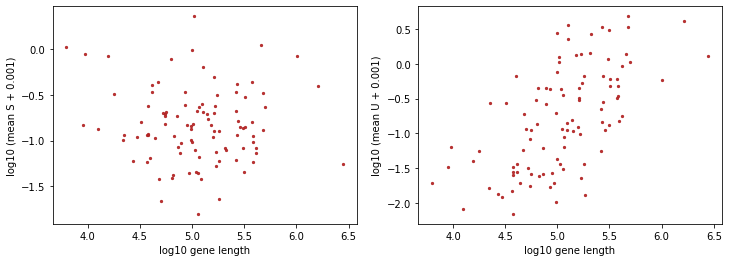

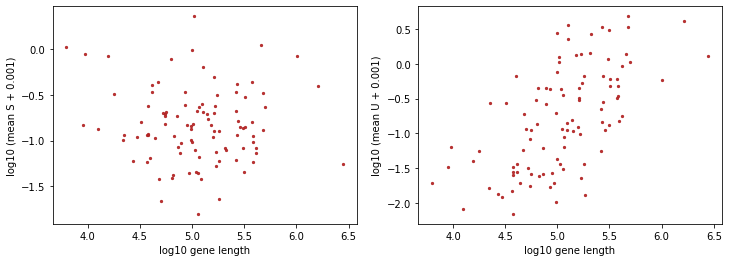

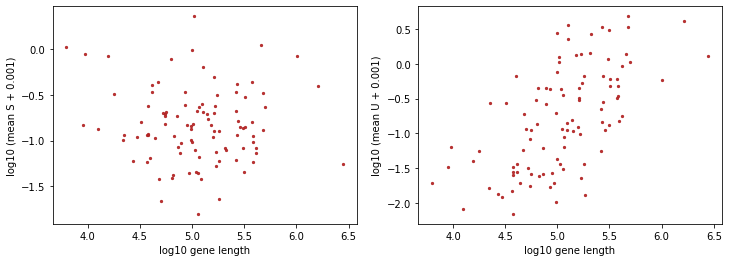

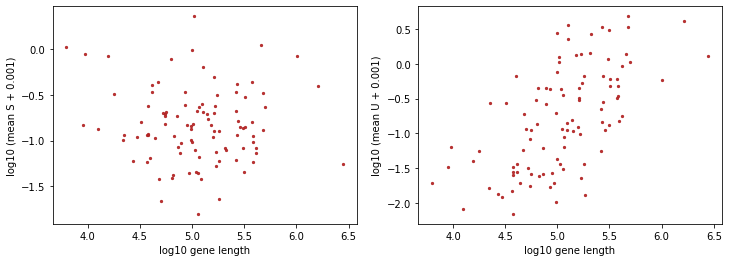

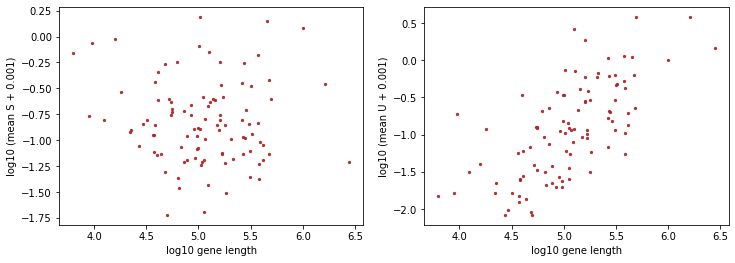

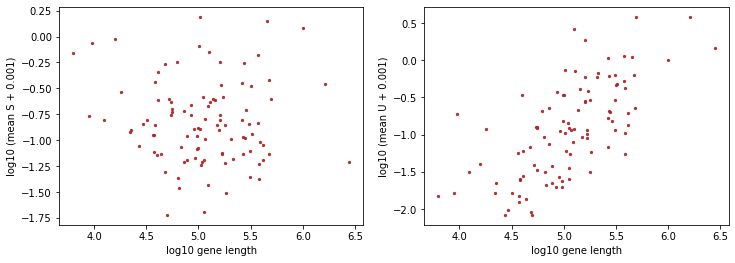

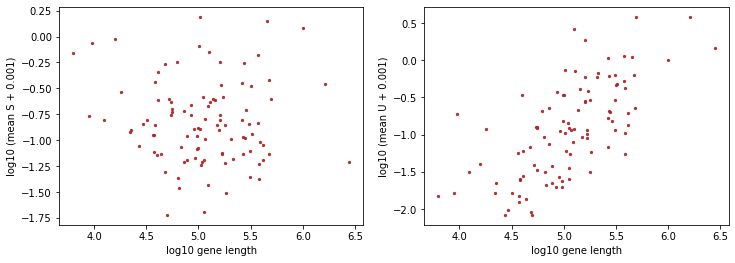

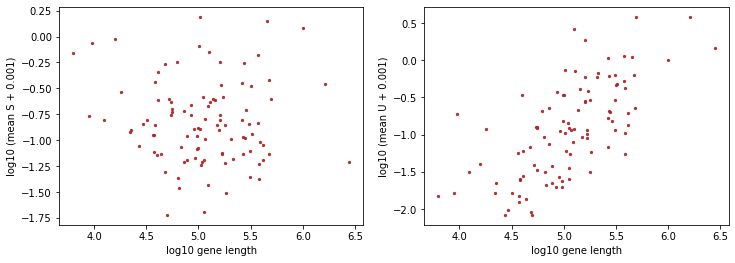

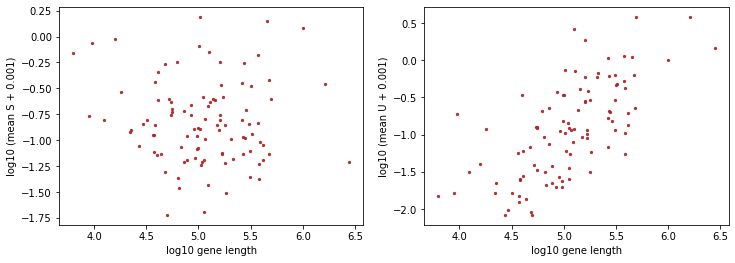

In [102]:

result_strings = []
for i in range(len(ks)-3): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


## **Analysis of Results**

In [103]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1')
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [104]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [i+1]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.median(np.median(np.array(results[i].all_klds)[:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in np.array(range(num_ks))+1 ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [105]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[:-3]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


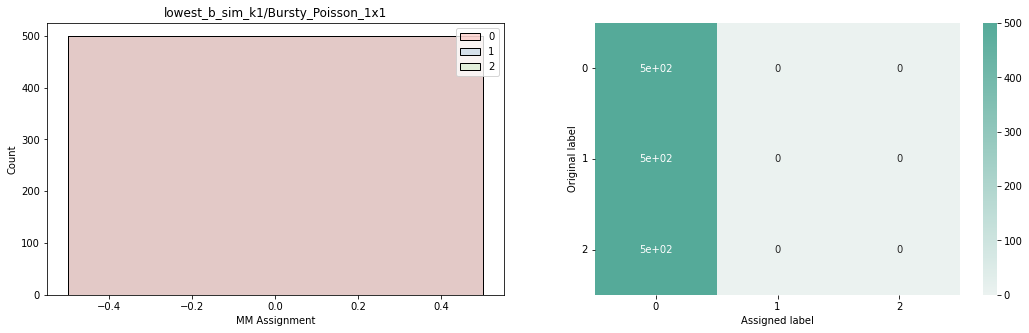

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


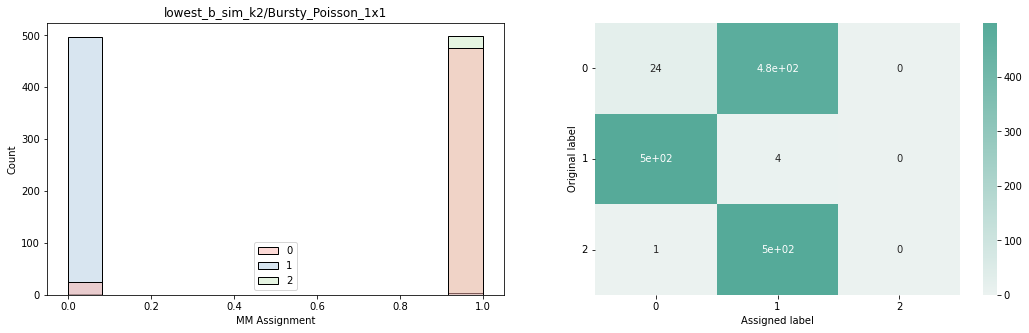

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


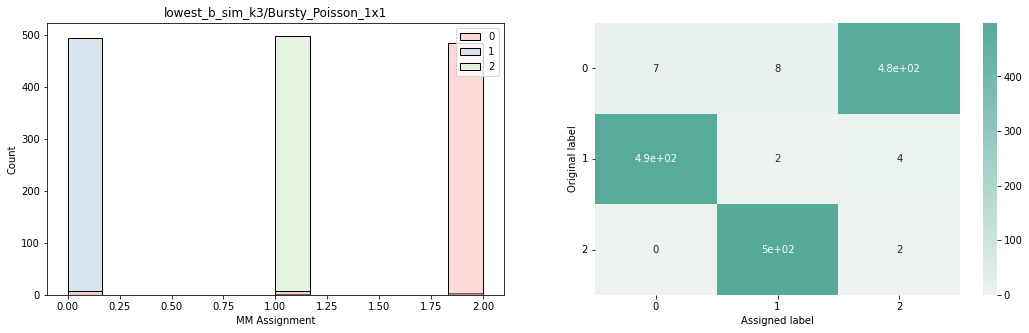

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


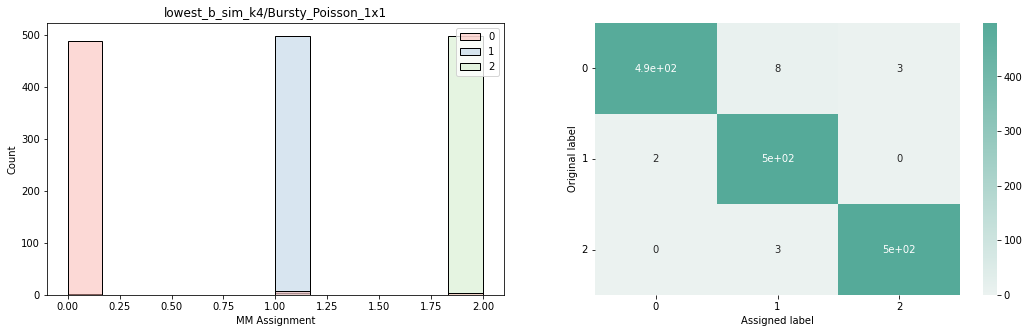

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


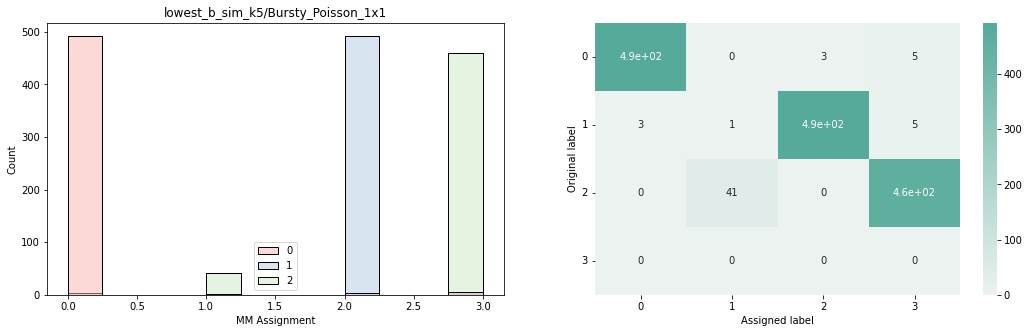

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


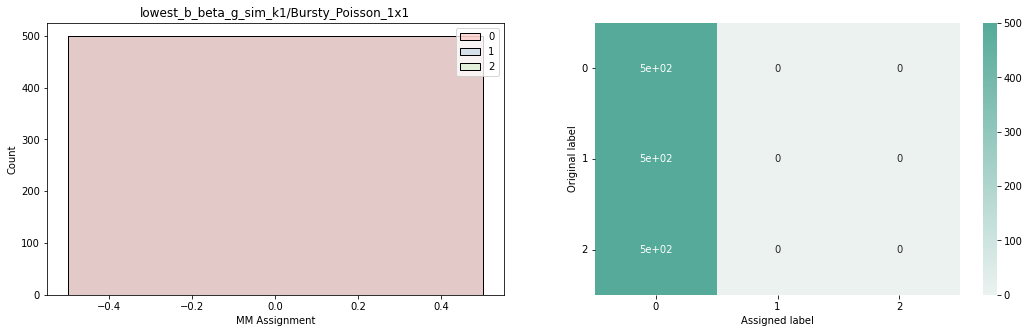

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


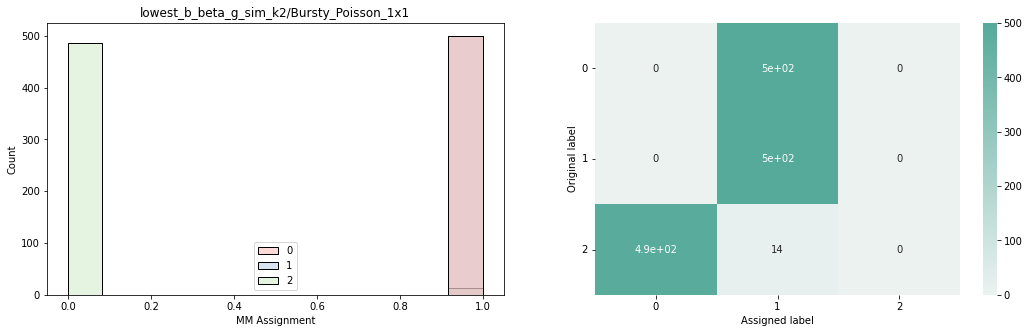

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


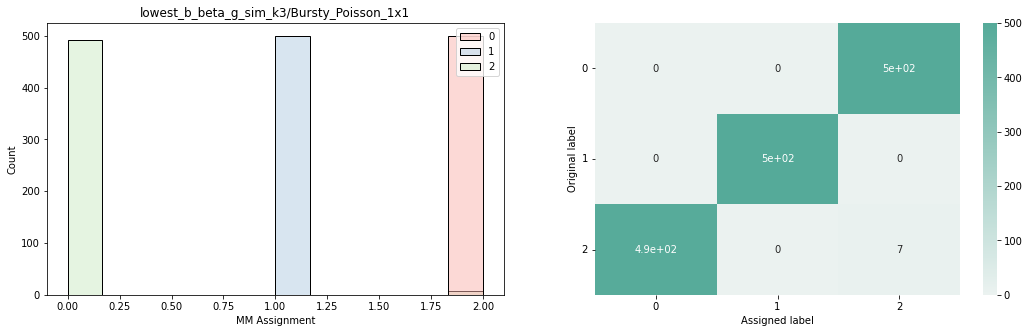

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


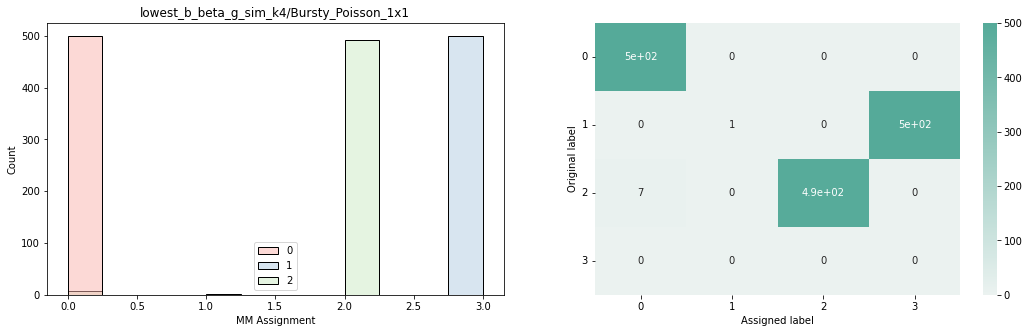

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


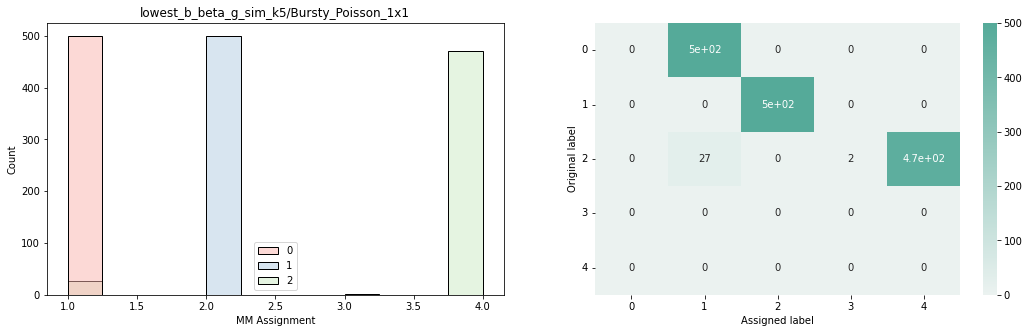

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


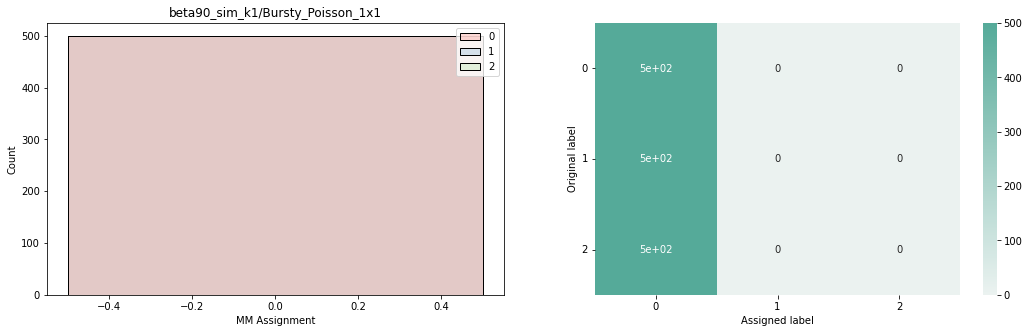

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


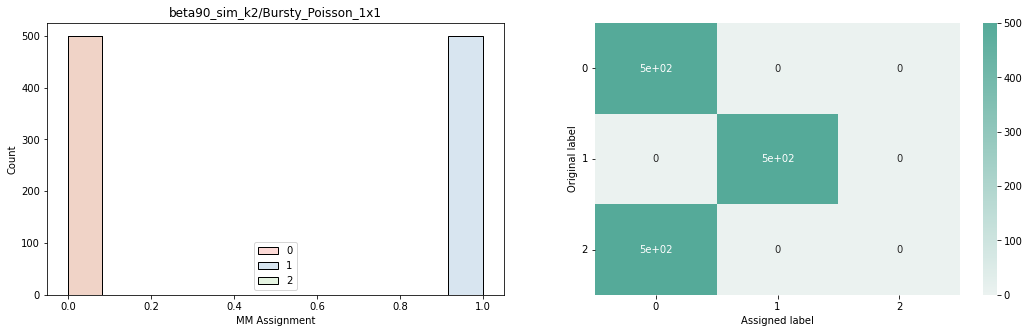

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


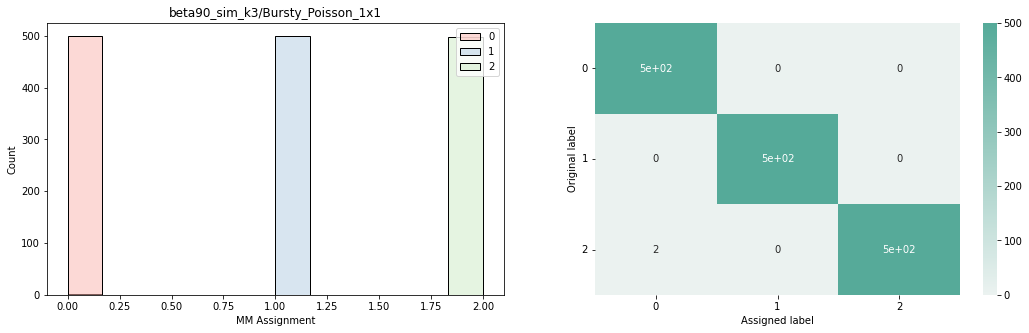

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


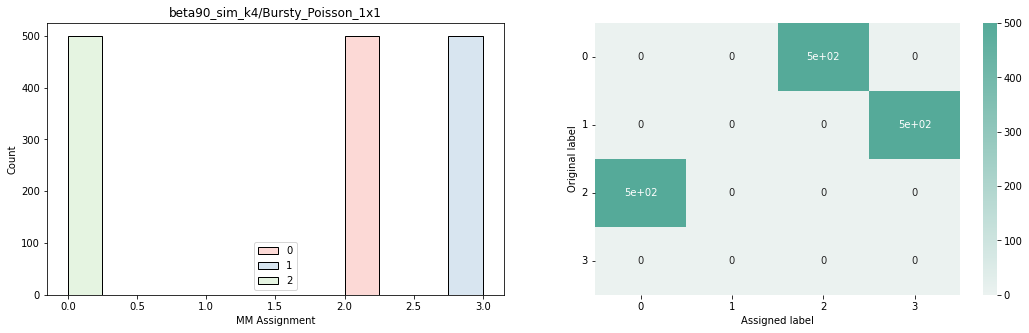

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


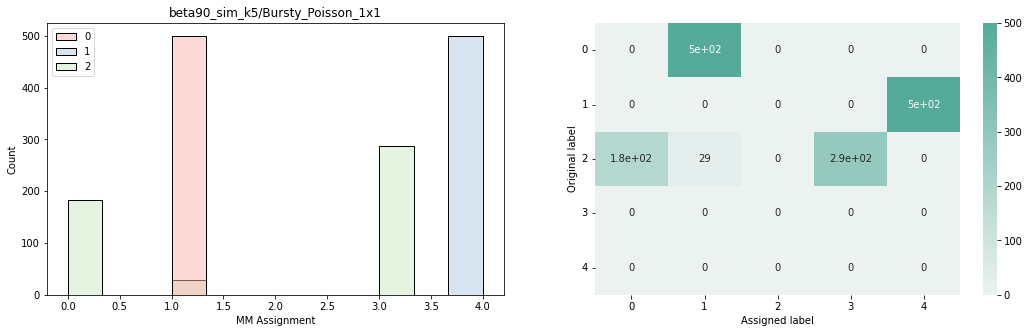

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


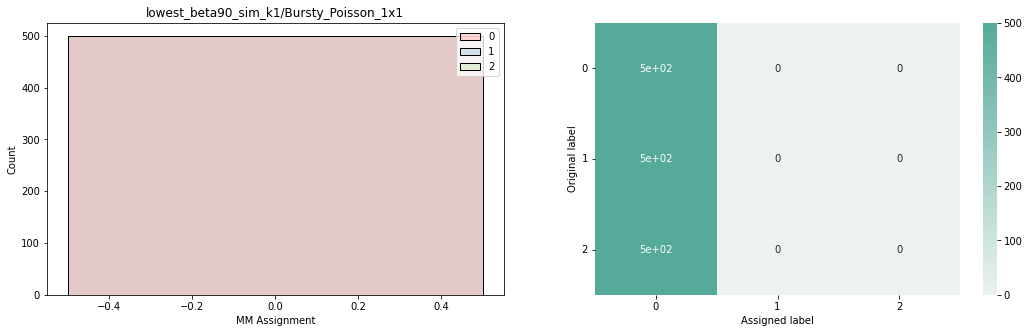

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


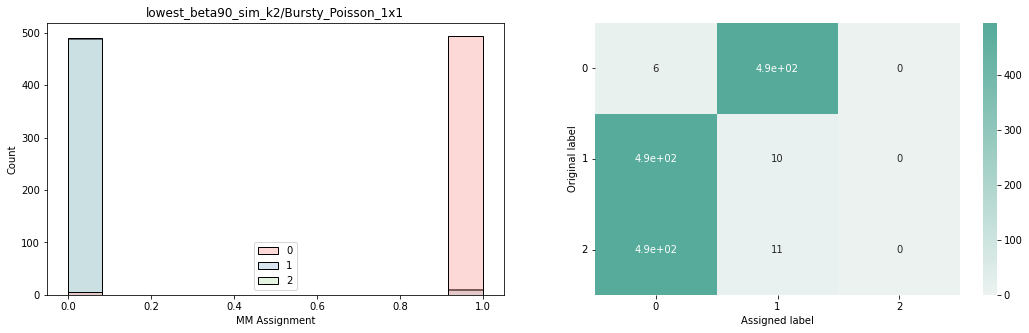

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


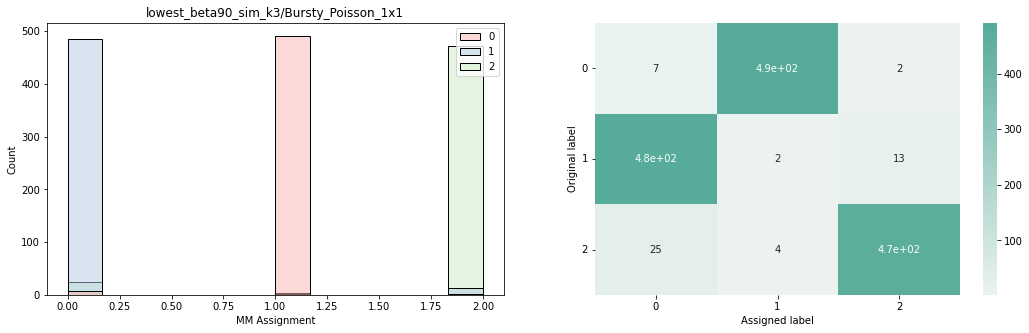

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


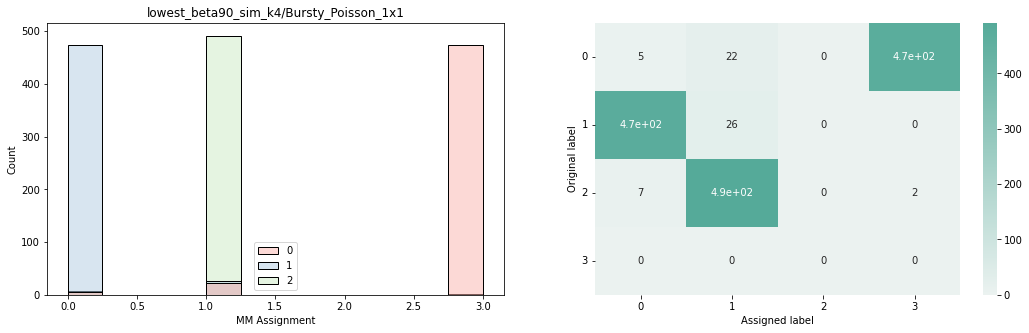

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


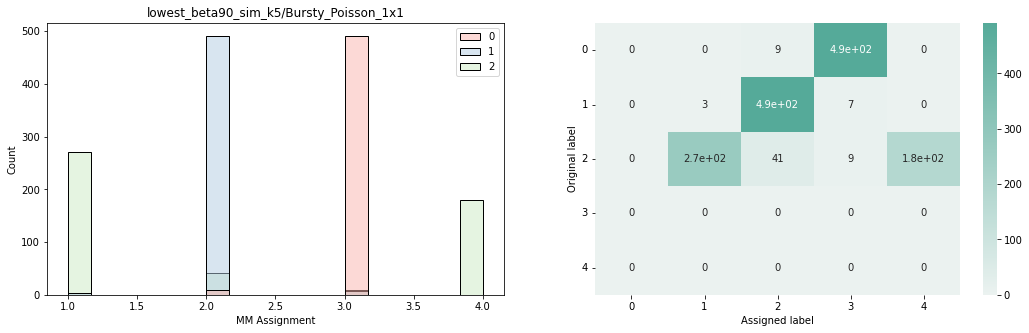

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


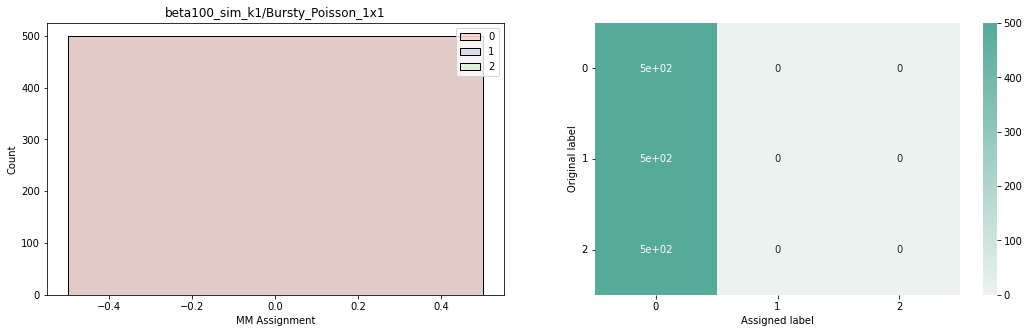

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


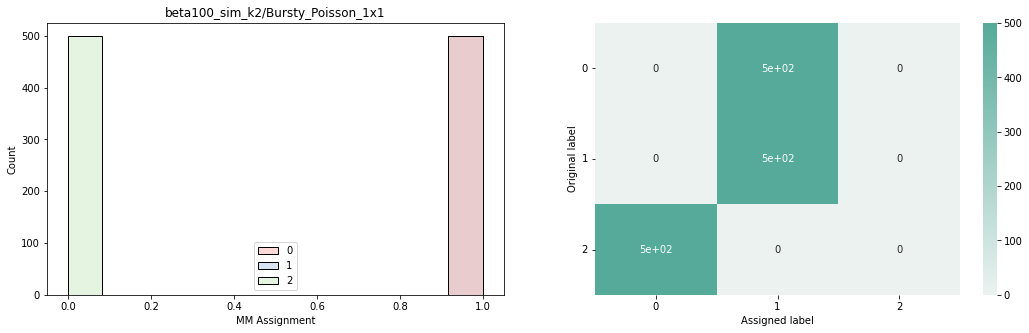

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


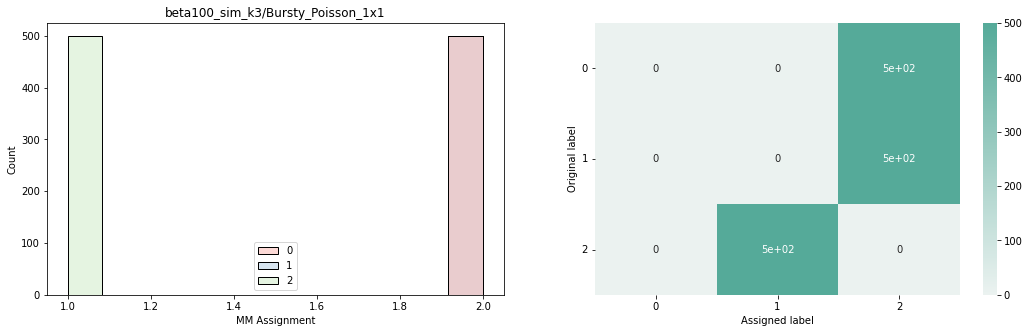

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


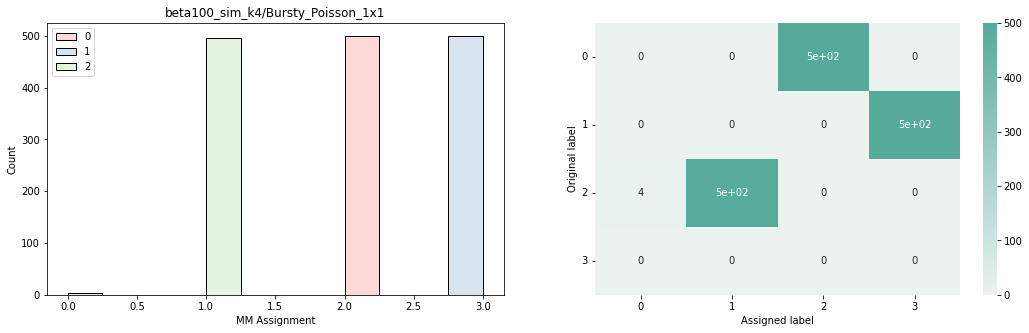

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


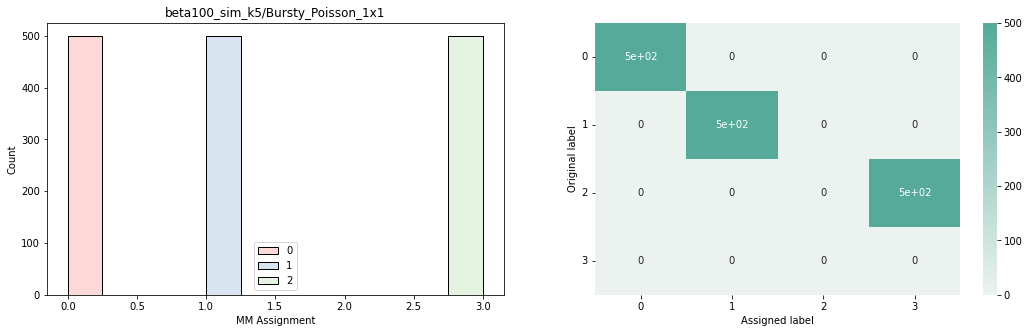

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


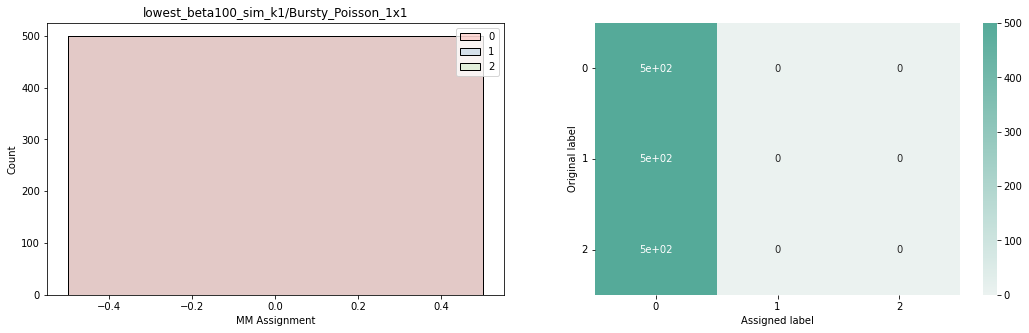

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


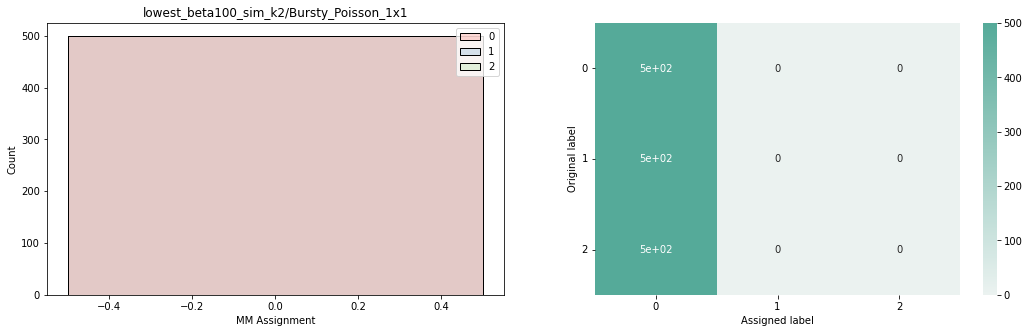

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


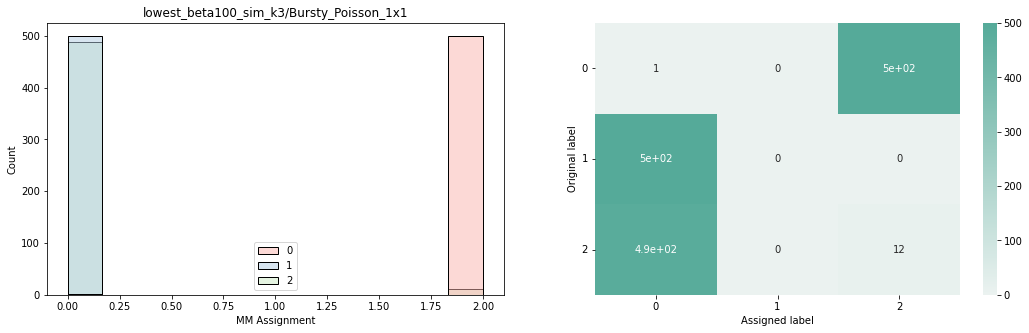

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


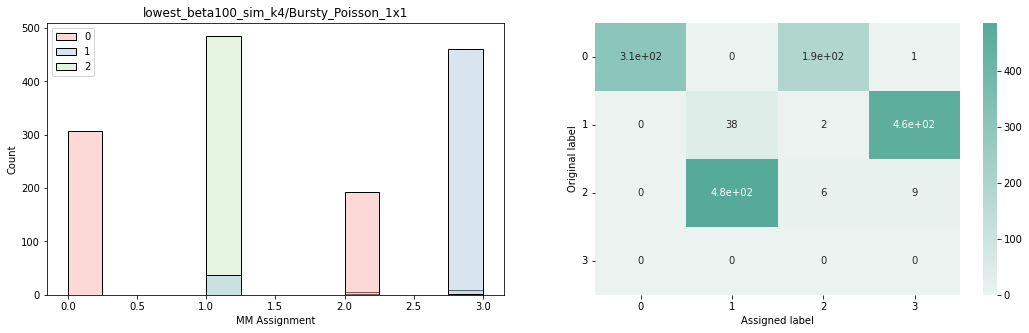

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


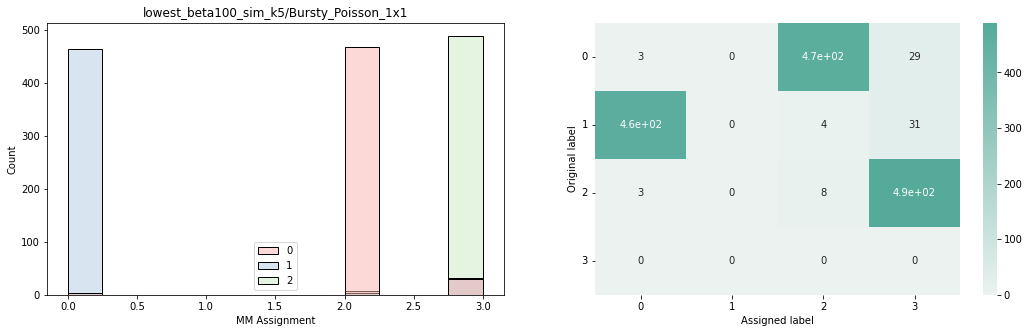

In [106]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230411_025_simTests_MM_1/','')
    vis_assign(np.array(all_assigns),r.assigns,title)


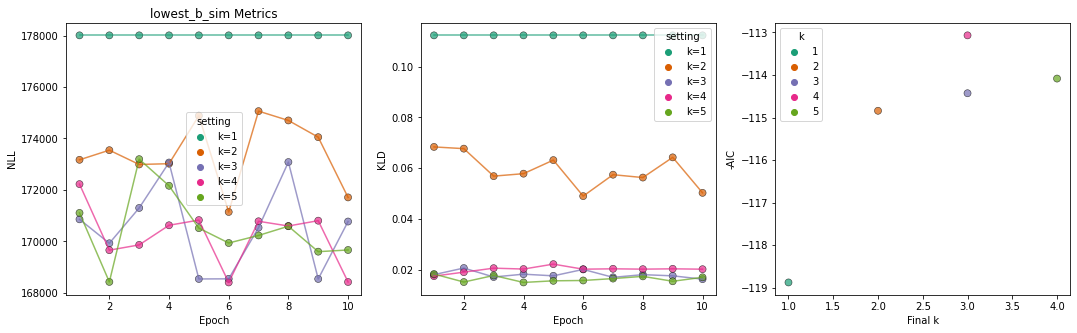

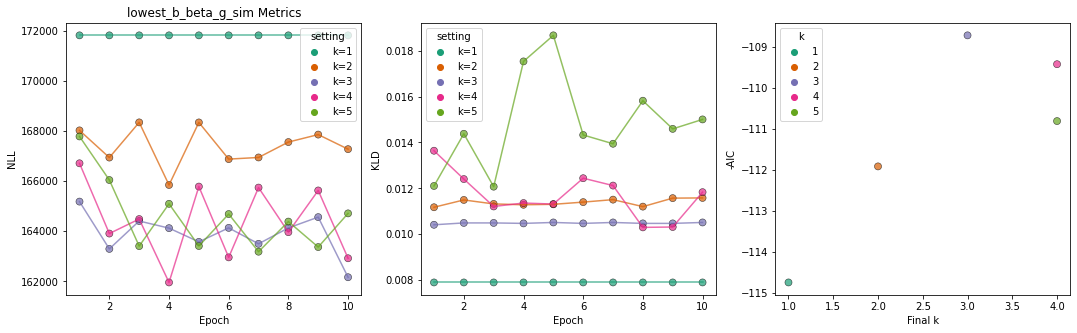

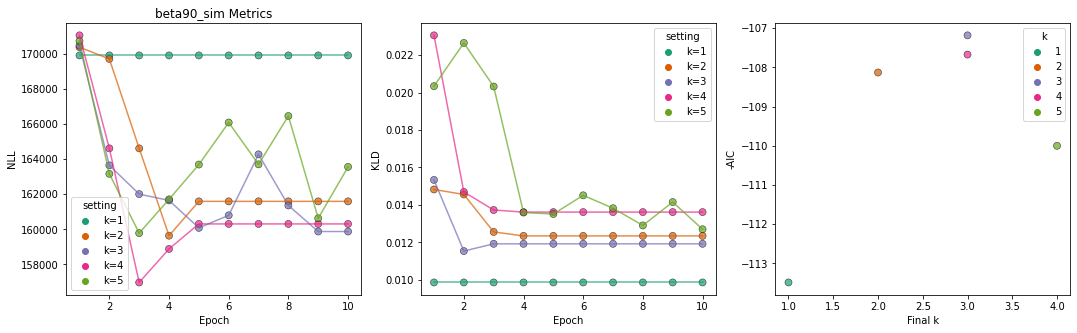

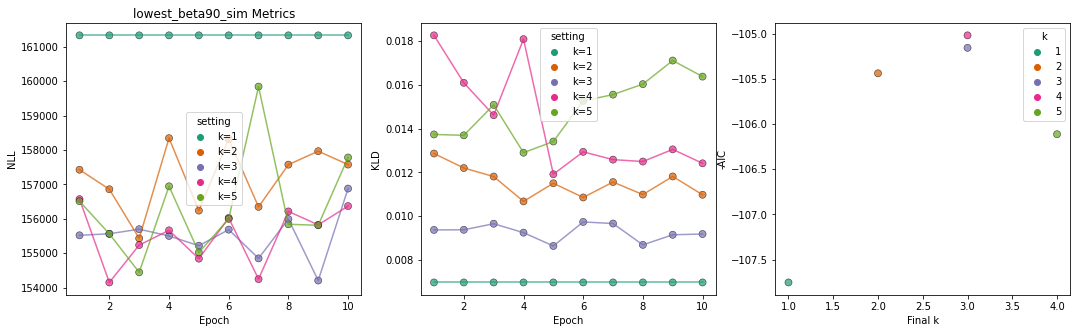

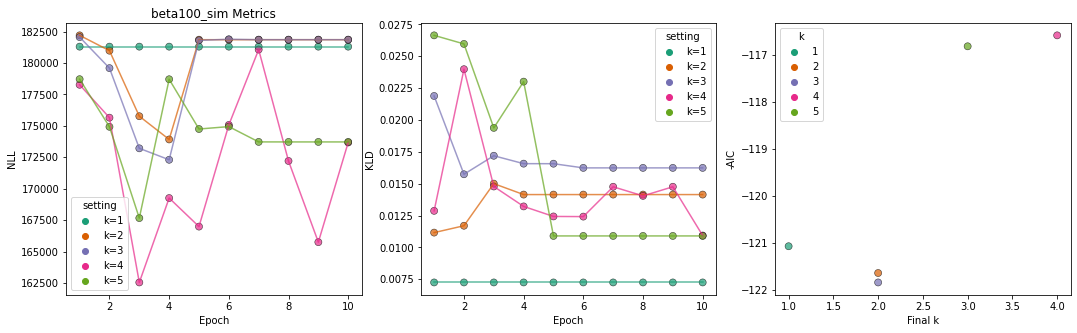

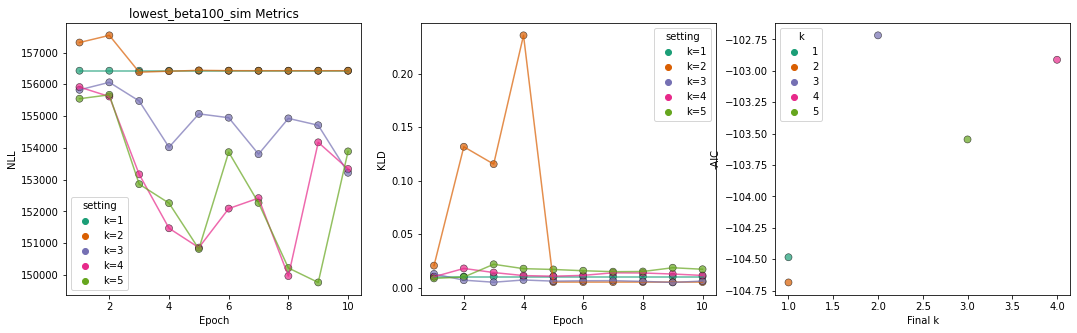

In [107]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)

(array([ 1.,  3., 10., 14., 23., 21., 10.,  9.,  7.,  2.]),
 array([-0.7320736 , -0.48348184, -0.23489008,  0.01370168,  0.26229344,
         0.5108852 ,  0.75947697,  1.00806873,  1.25666049,  1.50525225,
         1.75384401]),
 <BarContainer object of 10 artists>)

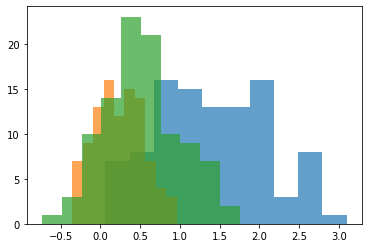

In [63]:
plt.hist(all_params[0][1,:,0],alpha=0.7)
plt.hist(all_params[0][1,:,2],alpha=0.7)
plt.hist(all_params[0][1,:,3],alpha=0.7)

(array([ 5.,  6.,  2.,  0.,  8., 27., 25., 18.,  7.,  2.]),
 array([-2.        , -1.45768334, -0.91536669, -0.37305003,  0.16926662,
         0.71158328,  1.25389994,  1.79621659,  2.33853325,  2.88084991,
         3.42316656]),
 <BarContainer object of 10 artists>)

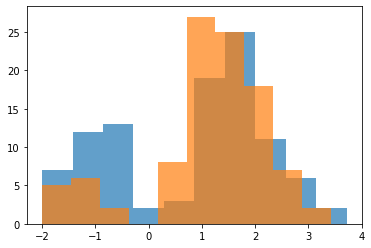

In [64]:
plt.hist(grid_point_results[3].param_estimates[:,0,0],alpha=0.7)
plt.hist(grid_point_results[3].param_estimates[:,0,1],alpha=0.7)

(array([12.,  0.,  0.,  9., 40., 29.,  7.,  2.,  0.,  1.]),
 array([-1.8 , -1.37, -0.94, -0.51, -0.08,  0.35,  0.78,  1.21,  1.64,
         2.07,  2.5 ]),
 <BarContainer object of 10 artists>)

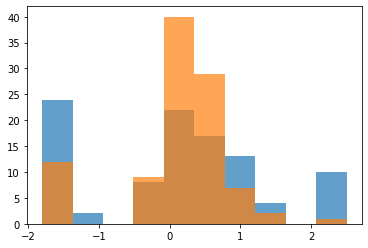

In [65]:
plt.hist(grid_point_results[3].param_estimates[:,1,0],alpha=0.7)
plt.hist(grid_point_results[3].param_estimates[:,1,1],alpha=0.7)

(array([13.,  0.,  1.,  4., 15., 24., 26., 13.,  3.,  1.]),
 array([-1.8       , -1.39324578, -0.98649157, -0.57973735, -0.17298313,
         0.23377108,  0.6405253 ,  1.04727952,  1.45403373,  1.86078795,
         2.26754216]),
 <BarContainer object of 10 artists>)

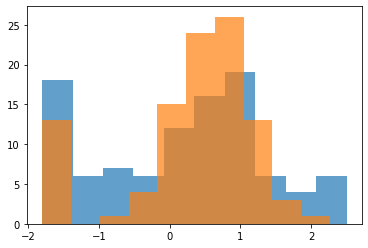

In [66]:
plt.hist(grid_point_results[3].param_estimates[:,2,0],alpha=0.7)
plt.hist(grid_point_results[3].param_estimates[:,2,1],alpha=0.7)

*******------------- old, no k-means init ------------********

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


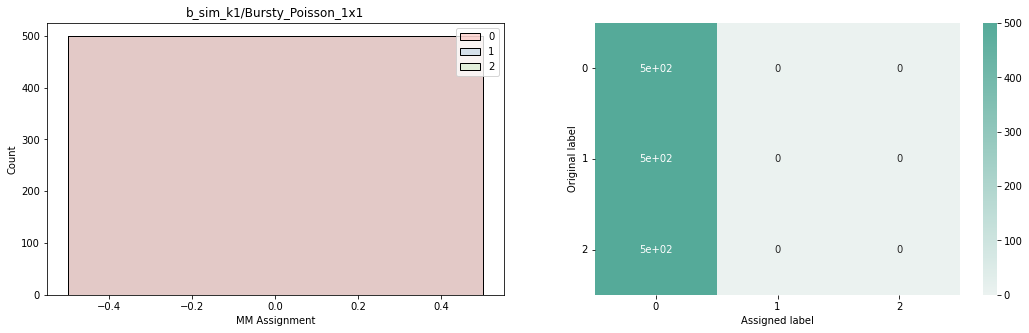

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


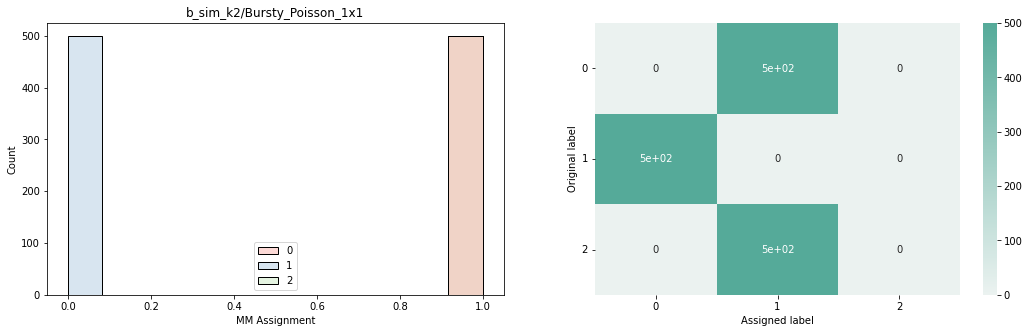

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


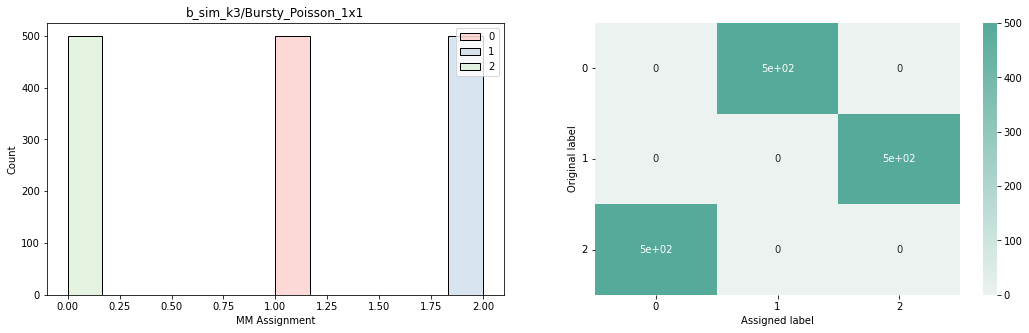

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


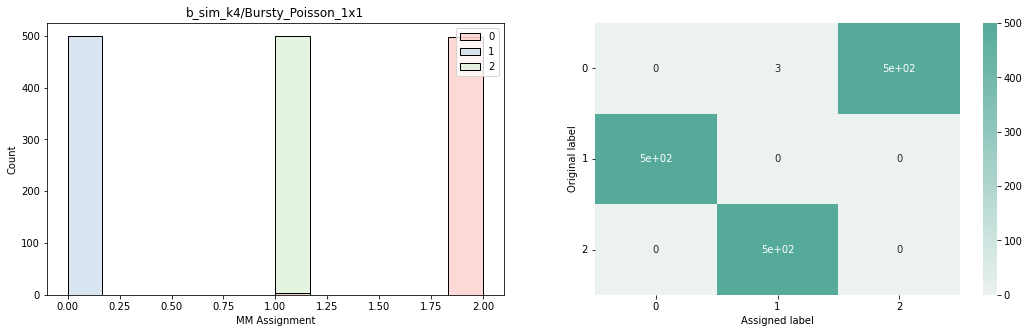

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


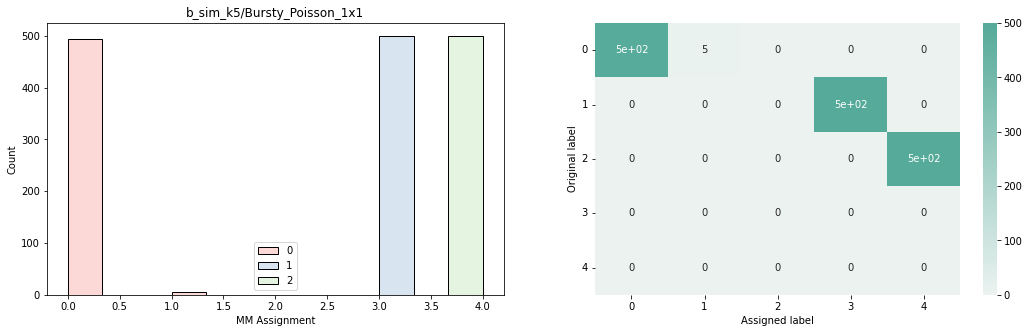

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


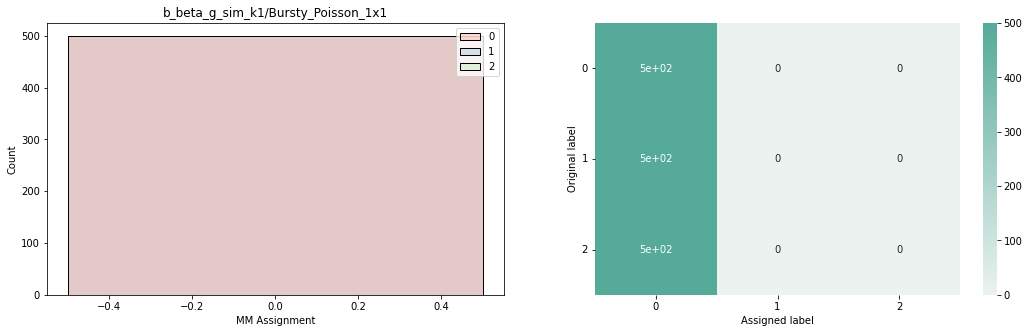

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


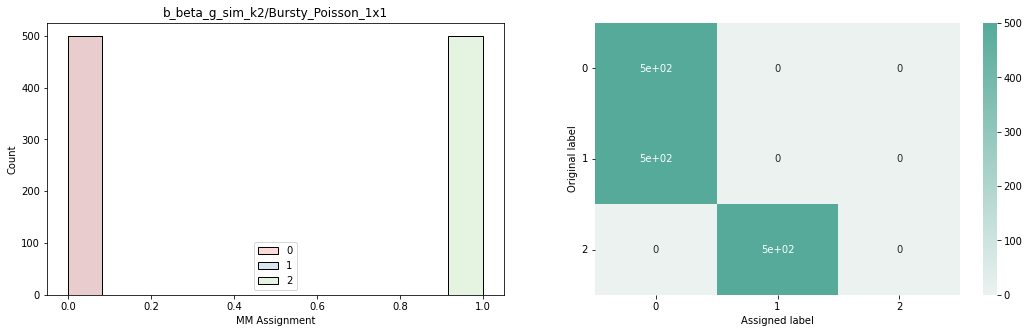

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


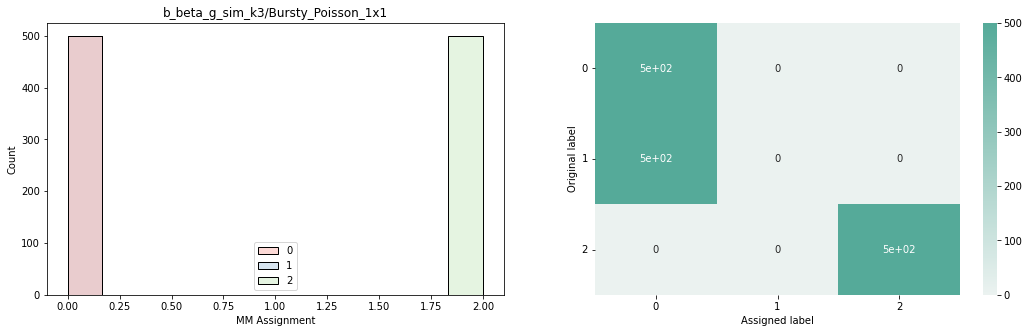

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


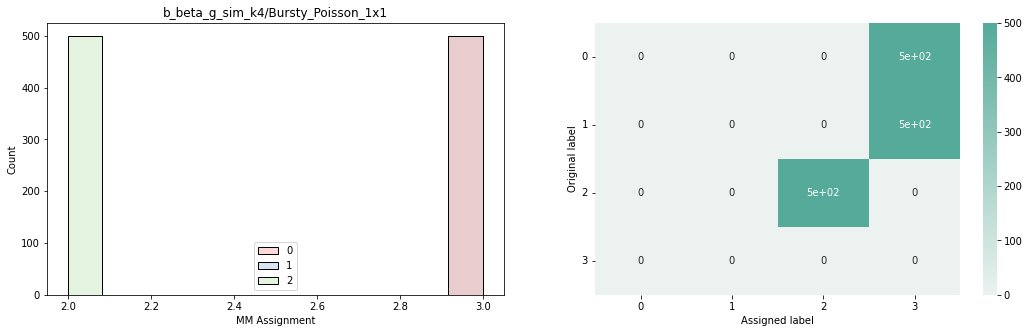

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


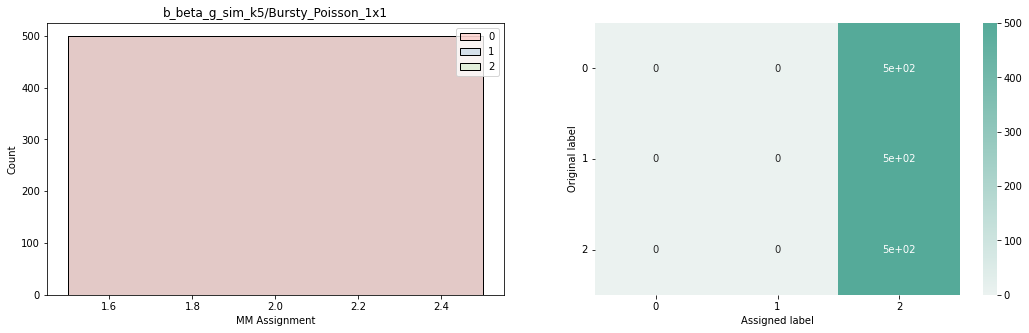

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


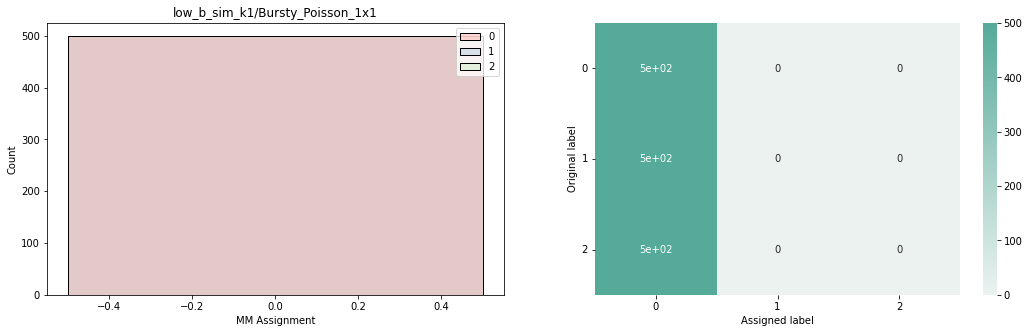

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


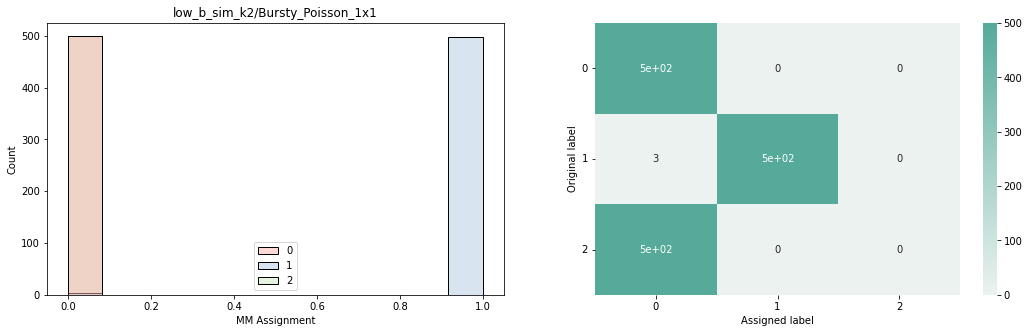

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


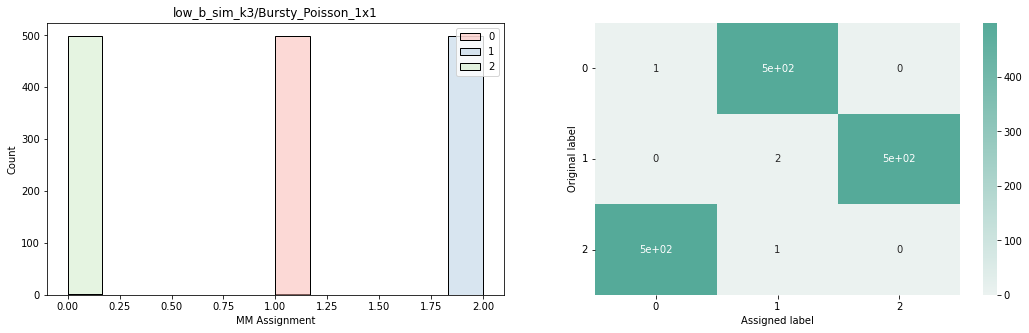

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


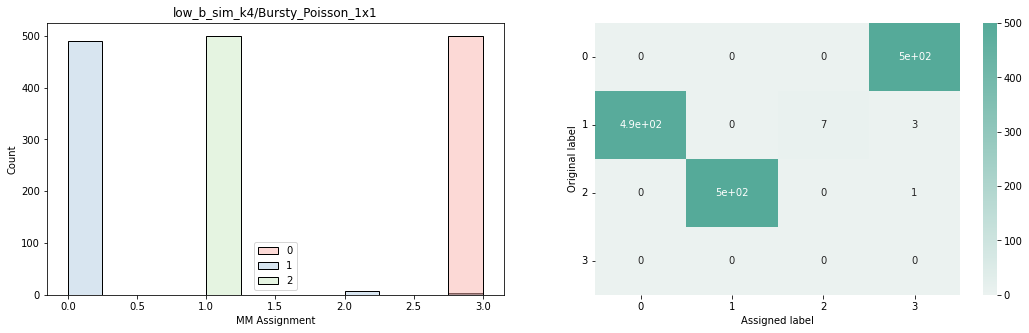

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


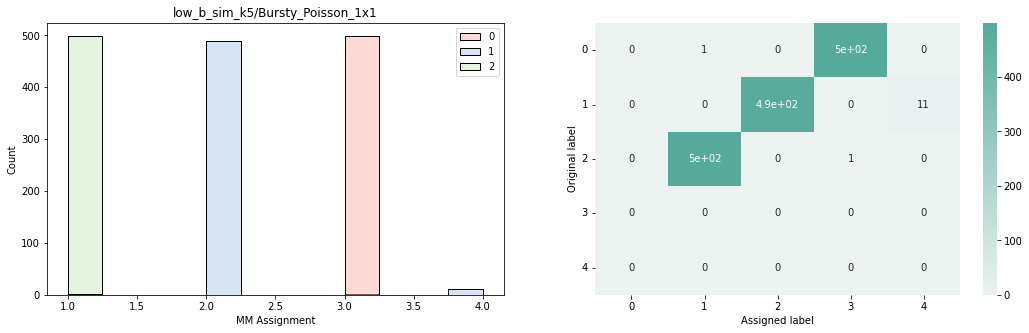

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


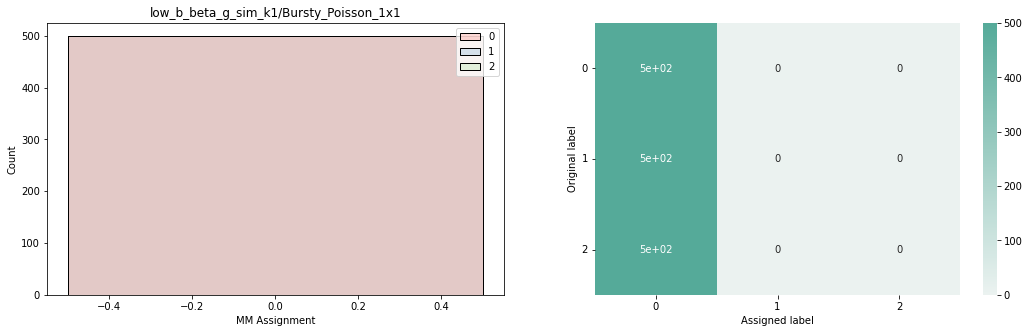

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


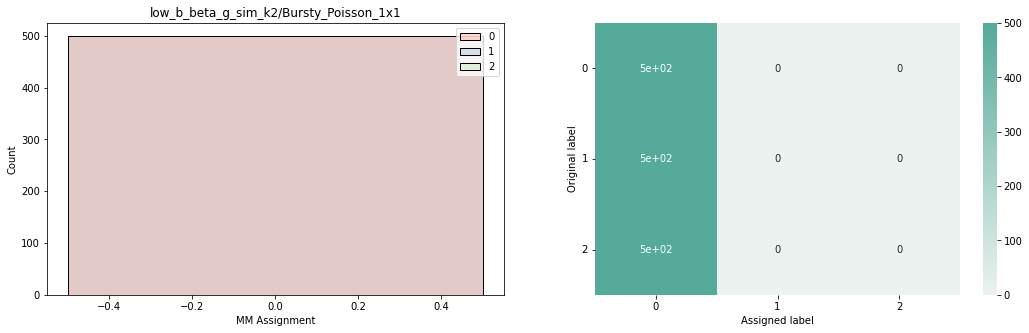

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


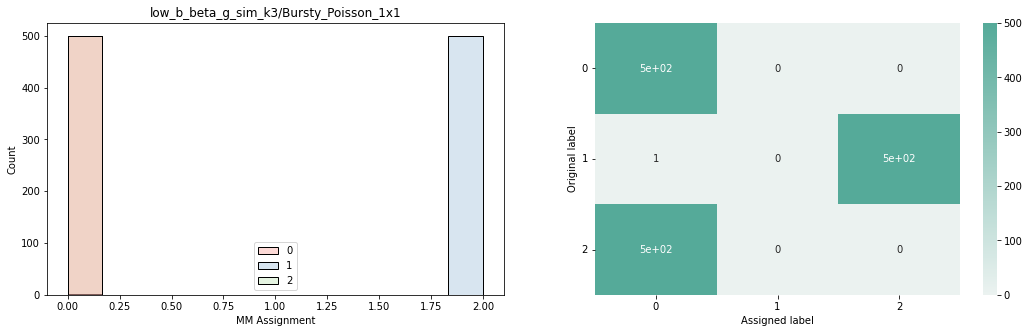

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


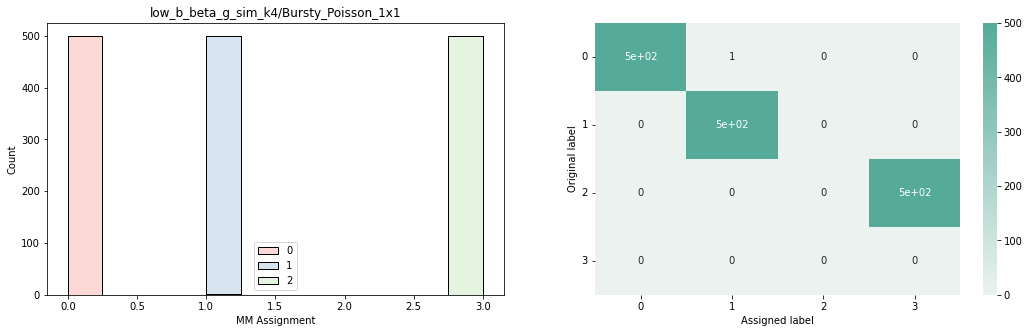

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


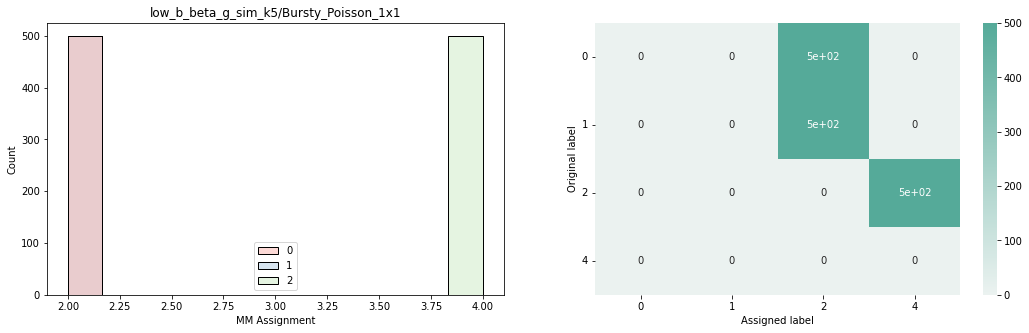

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


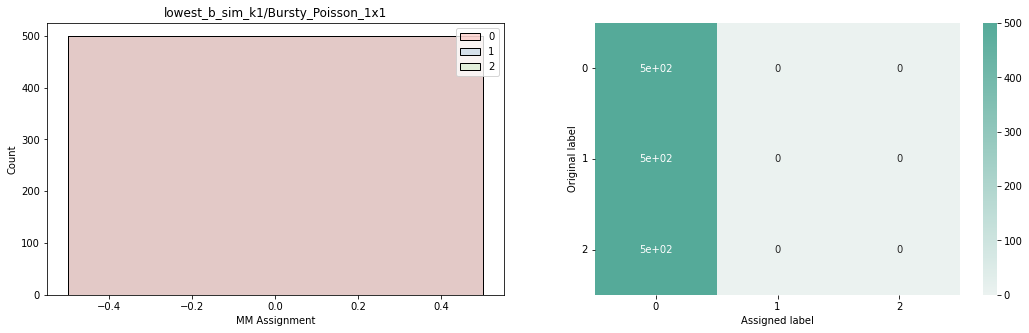

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


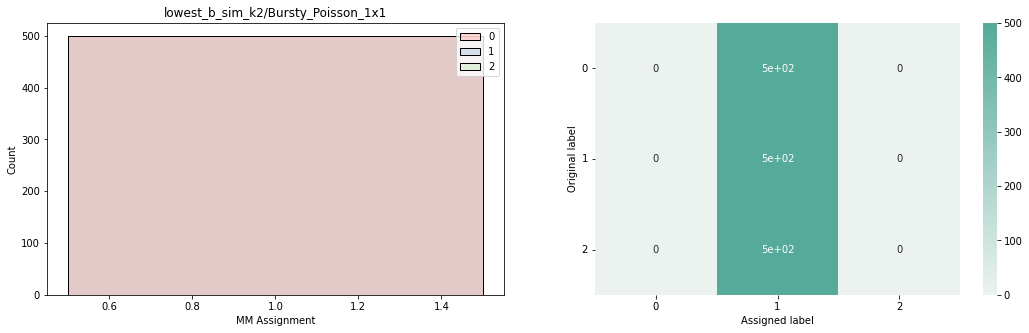

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


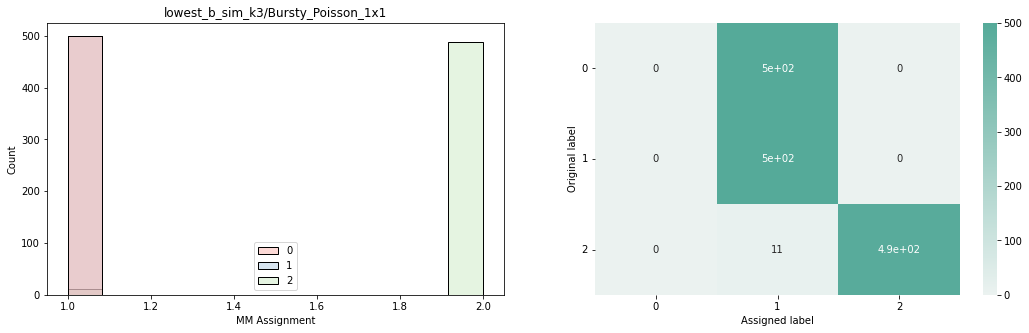

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


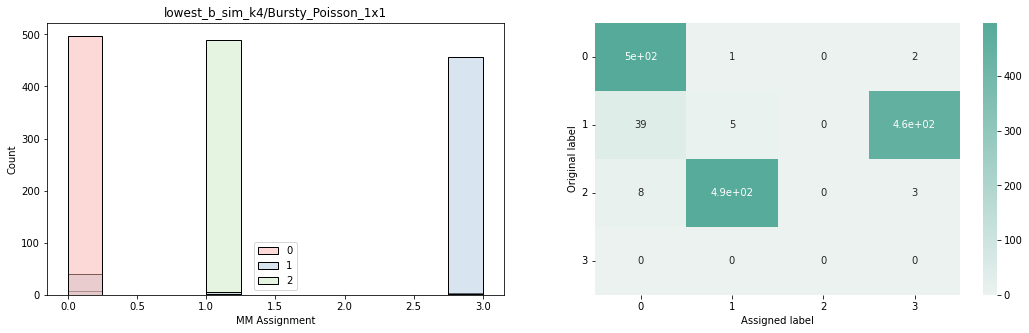

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


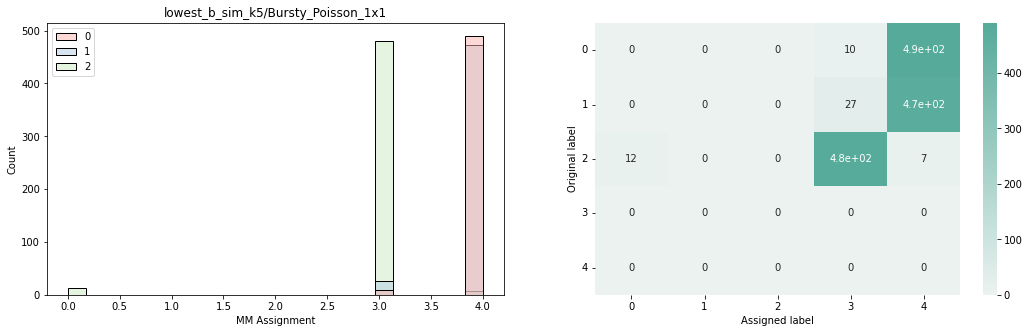

In [371]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230404_025_simTests_MM_1/','')
    vis_assign(np.array(all_assigns),r.assigns,title)


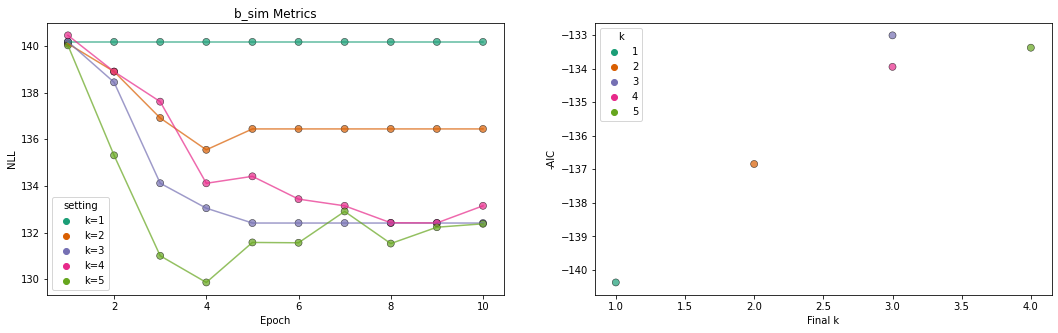

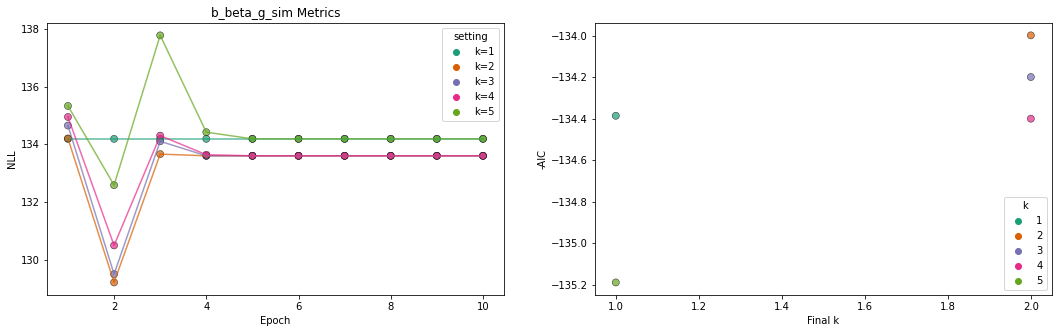

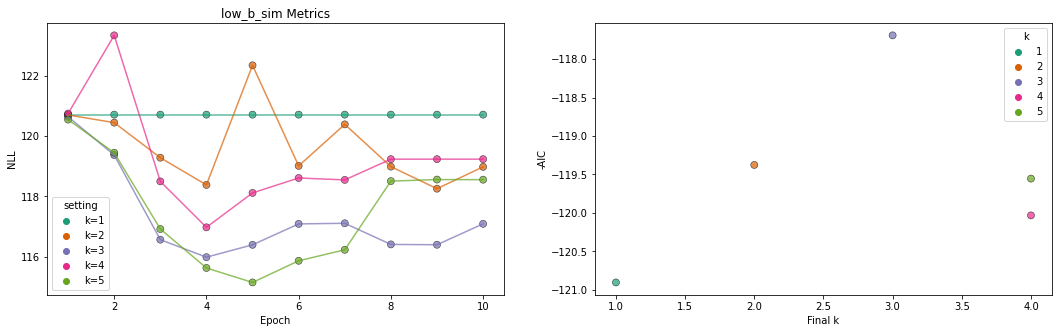

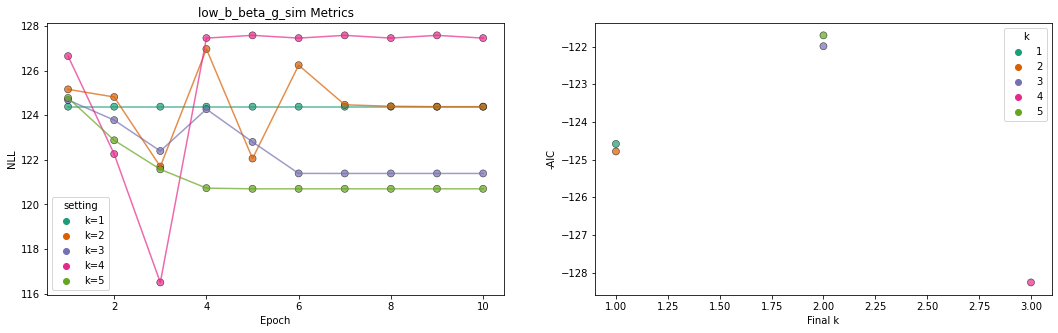

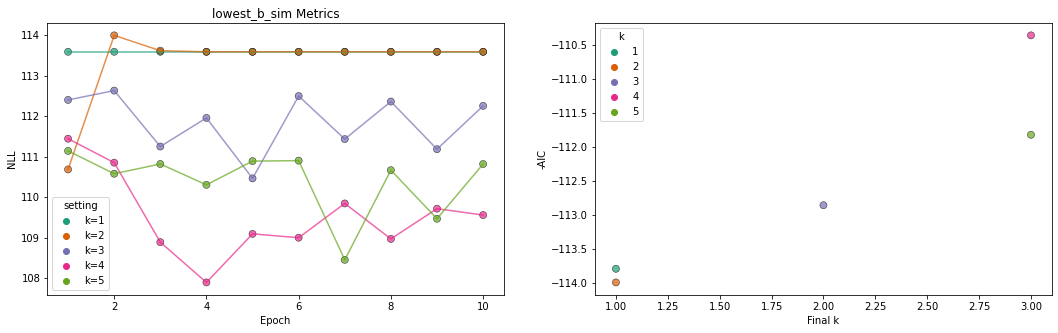

In [372]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)

In [172]:
search_data.M[:,0].shape

(2,)

### **Compare Monod Fits to Simulation and MM Fits**

In [211]:
#Check results for burst size > 1
def get_logL(ps,counts,search_data):
    bs = ps[:,0]
    betas = ps[:,1]
    gammas = ps[:,2]
    
    EPS=1e-15
    
    logL = 0
    
    for g in range(n_genes):
        

        x = counts[:,g,:].T
        x = x.astype(int)
        
        b = 10**bs[g]
        beta = 10**betas[g]
        gamma = 10**gammas[g]
        
        
        
        g_len = lens_sub[g]

        lam_n = 10**((glob_samp[0]) + np.log10(g_len))
        lam_m = 10**(glob_samp[1])

        p = np.log10(np.asarray([b,beta,gamma])) #[b,beta,gamma]
        burst_model = BurstModel('Poisson')

        #max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
        #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

        #max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

#         max_domain = np.array([np.amax(x[0,:])+10,np.amax(x[1,:])+10])
#         print(max_domain)
        #max_domain = [int(i) for i in max_domain]

        proposal = burst_model.get_Pss(p,search_data.M[:, g],np.log10([lam_n,lam_m]))

        proposal[proposal < EPS] = EPS

        proposal = proposal[tuple(x)]
        logL += np.sum(np.log(proposal))
        
    return logL

In [143]:
d = all_params[0][0,:,:]
d[:,[0,1,2]].shape


(100, 3)

In [162]:
all_counts[0][0,0,0]

0.0

In [212]:
#b_sim
#0,0,2or7     0,0,2
def plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,0,0],clus_inds=[0,0,0]):
    
    b_sim_monod = sr[res_inds[0]].param_estimates[clus_inds[0]]
    b_sim_true = all_params[res_inds[1]][clus_inds[1],:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    b_sim_mm = grid_point_results[res_inds[2]].param_estimates[:,:,clus_inds[2]]
    
    
    #Get true counts + print likelihoods
    true_counts = all_counts[res_inds[1]][0:500,:,:]
    
    print('True Param LogL: ',get_logL(b_sim_true[:,[0,2,3]],true_counts,search_data))
    print('Monod Param LogL: ',get_logL(b_sim_monod,true_counts,search_data))
    print('MM Param LogL: ',get_logL(b_sim_mm,true_counts,search_data))
    
    
    
    
    
    rho =[]
    p = []   
    
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_monod[:,0])+list(b_sim_true[:,0])+list(b_sim_mm[:,0])
    comps['beta'] = list(b_sim_monod[:,1])+list(b_sim_true[:,2])+list(b_sim_mm[:,1])
    comps['gamma'] = list(b_sim_monod[:,2])+list(b_sim_true[:,3])+list(b_sim_mm[:,2])
    comps['setting'] = ['Monod']*n_genes + ['Sim']*n_genes + ['MM']*n_genes


    #Plot param histograms
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))

    #b,beta,gamma histograms
    sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0])
    sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1])
    sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2])
    



    #Plot correlations
    comps_monod = comps[comps.setting.isin(['Monod'])]
    comps_true = comps[comps.setting.isin(['Sim'])]
    comps_mm = comps[comps.setting.isin(['MM'])]
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_true['b']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,0])
    #ax[1,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_true['b']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['b']),y=list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,1],legend=False)
    #ax[1,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),list(comps_true['beta']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,2],legend=False)
    #ax[1,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_true['gamma']))[0]]
    
    ax[1,0].set_xlabel('Monod')
    ax[1,0].set_ylabel('True')



    #monod v mm
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,0])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_mm['b']))[0]]
    

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,1],legend=False)
    #ax[2,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1])
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_mm['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,2],legend=False)
    #ax[2,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_mm['gamma']))[0]]
    
    ax[2,0].set_xlabel('Monod')
    ax[2,0].set_ylabel('MM')


    #mm v true
    sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,0])
    #ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1])
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,1],legend=False)
    #ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1])
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,2],legend=False)
    #ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]
    
    ax[3,0].set_xlabel('MM')
    ax[3,0].set_ylabel('True')
    
    
    for i, a in enumerate(ax.flat):

        if i not in [0,1,2]:
            bot,top = a.get_ylim()
            l,r = a.get_xlim()

            newl = np.min([bot,l])
            newr = np.max([top,r])

            a.set_xlim((newl,newr))
            a.set_ylim((newl,newr))
            
            a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
            a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)
            
            a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)
        
        

    
    plt.show()

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
True Param LogL:  -54165.43722778974
Monod Param LogL:  -57057.68313218705
MM Param LogL:  -57067.412148366435


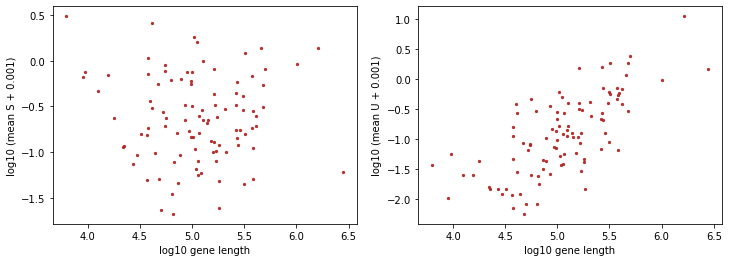

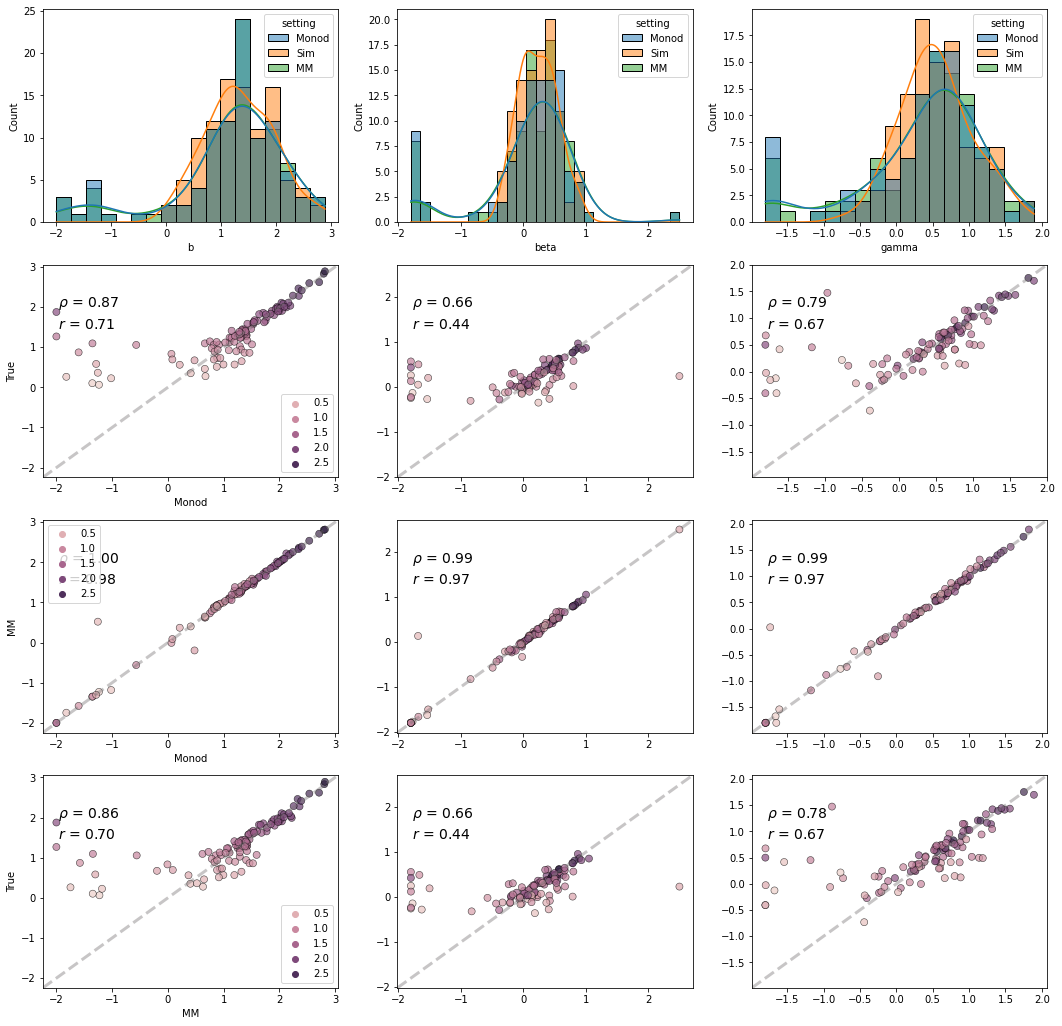

In [215]:
    
search_data = monod.extract_data.extract_data(loom_filepaths[2], transcriptome_filepath, dataset_names[2],
                dataset_strings[2], dir_string, dataset_attr_names=attribute_names,cf=cf[2])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,0,2],clus_inds=[0,0,2])

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
True Param LogL:  -54165.43722778974
Monod Param LogL:  -57057.68313218705
MM Param LogL:  -59750.19509416986


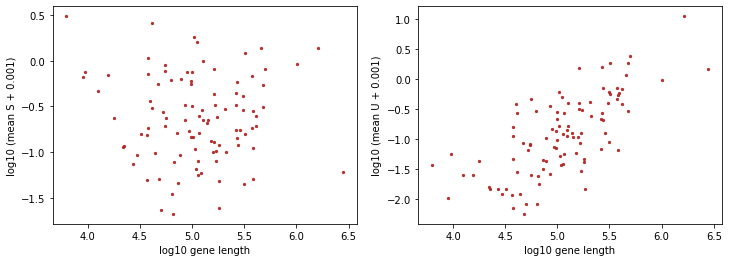

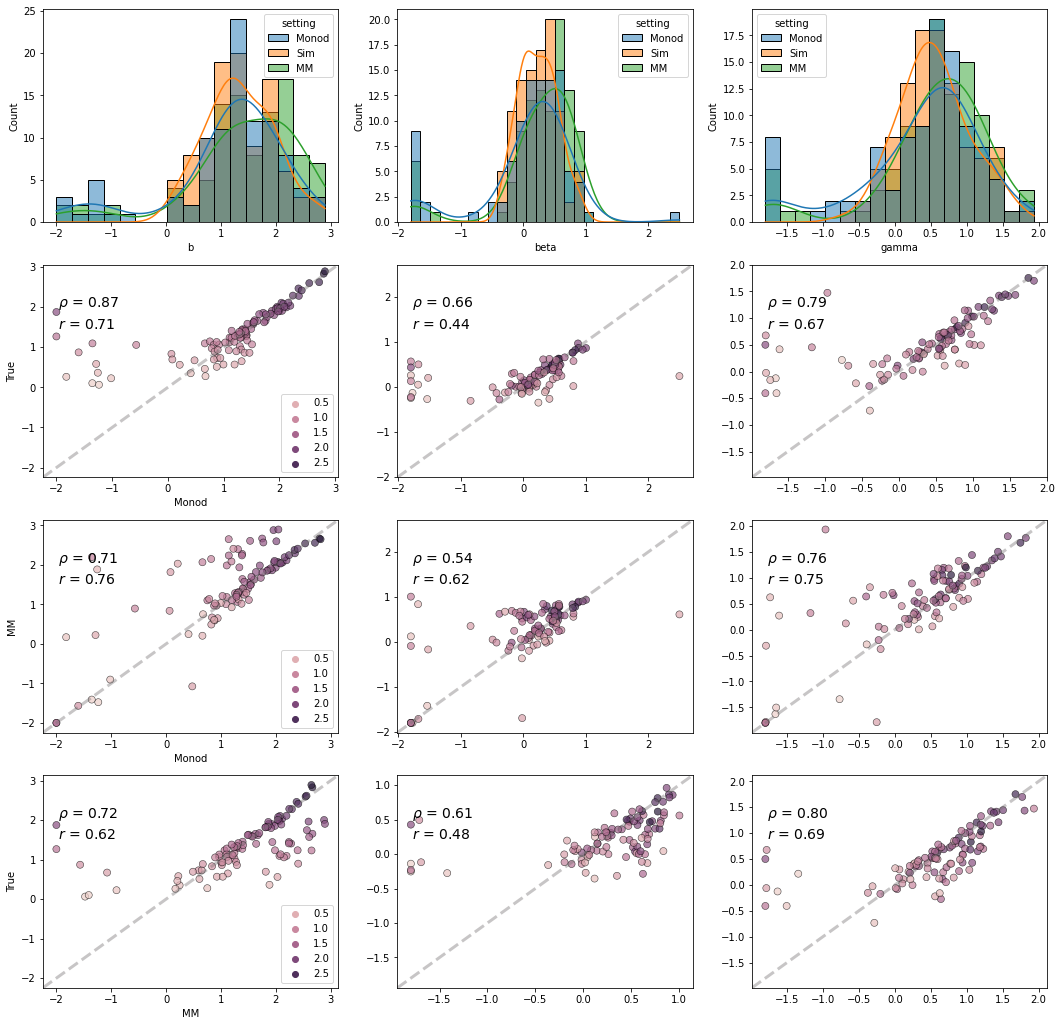

In [217]:
search_data = monod.extract_data.extract_data(loom_filepaths[2], transcriptome_filepath, dataset_names[2],
                dataset_strings[2], dir_string, dataset_attr_names=attribute_names,cf=cf[2])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,0,0],clus_inds=[0,0,0])

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
True Param LogL:  -52987.685462219364
Monod Param LogL:  -52850.494514721024
MM Param LogL:  -52870.525998360106


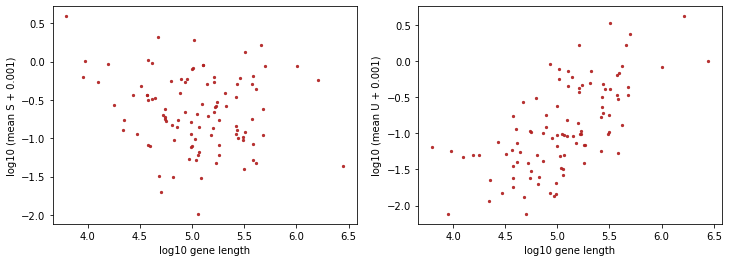

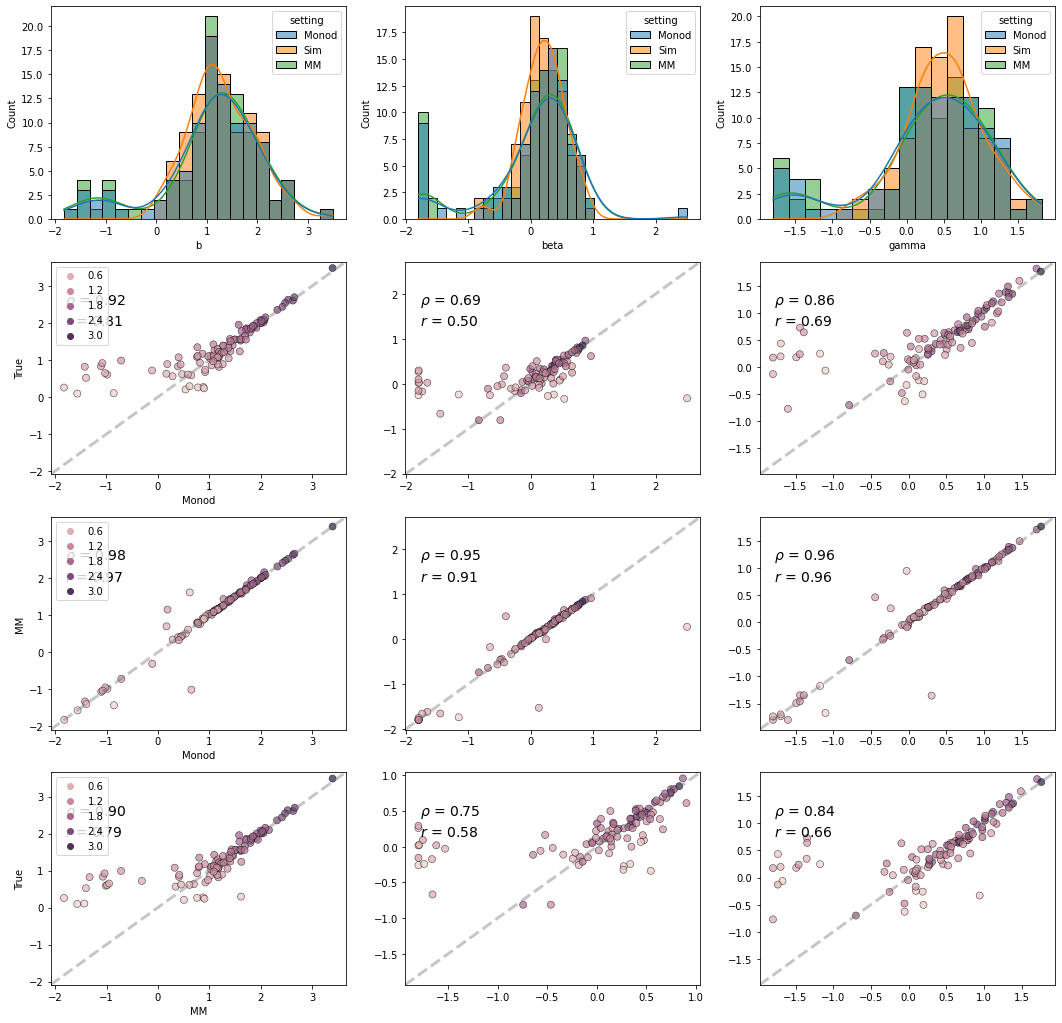

In [218]:
search_data = monod.extract_data.extract_data(loom_filepaths[7], transcriptome_filepath, dataset_names[7],
                dataset_strings[7], dir_string, dataset_attr_names=attribute_names,cf=cf[7])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[1,1,7],clus_inds=[0,0,2])


INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
True Param LogL:  -52987.685462219364
Monod Param LogL:  -52850.494514721024
MM Param LogL:  -56088.71416188942


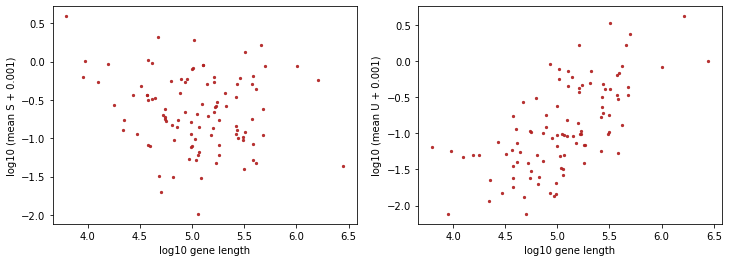

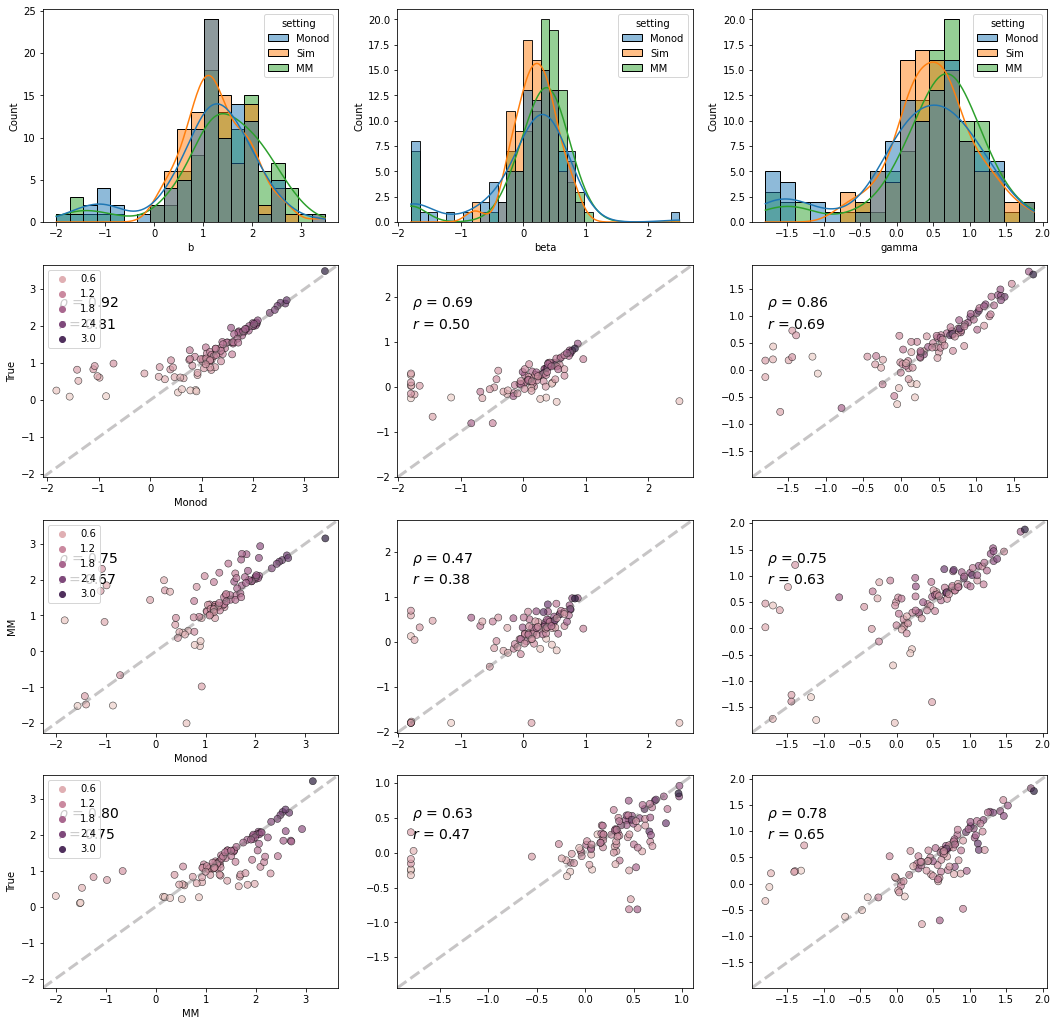

In [219]:
search_data = monod.extract_data.extract_data(loom_filepaths[7], transcriptome_filepath, dataset_names[7],
                dataset_strings[7], dir_string, dataset_attr_names=attribute_names,cf=cf[7])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[1,1,5],clus_inds=[0,0,0])


In [220]:
dataset_names[17]

'lowest_beta90_sim_k3'

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.


IndexError: index 13 is out of bounds for axis 0 with size 13

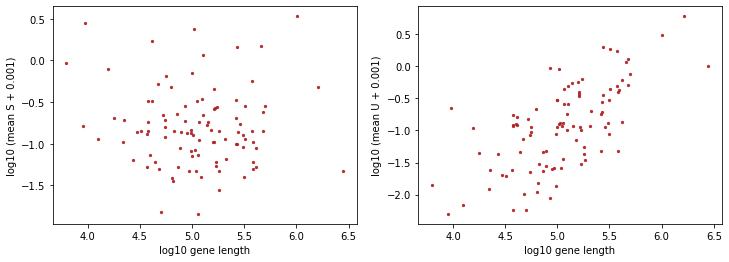

In [223]:
search_data = monod.extract_data.extract_data(loom_filepaths[17], transcriptome_filepath, dataset_names[17],
                dataset_strings[17], dir_string, dataset_attr_names=attribute_names,cf=cf[17])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[2,2,17],clus_inds=[0,0,1])



INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230411_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230411_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.


IndexError: index 13 is out of bounds for axis 0 with size 13

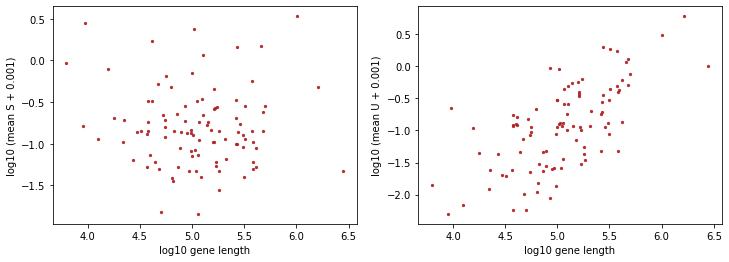

In [224]:
search_data = monod.extract_data.extract_data(loom_filepaths[17], transcriptome_filepath, dataset_names[17],
                dataset_strings[17], dir_string, dataset_attr_names=attribute_names,cf=cf[17])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[2,2,15],clus_inds=[0,0,0])



In [ ]:
#Plot mean correlations
k1 = all_counts[0][0:500,:,:]
u_means = np.mean(k1[:,:,0],axis=0)
s_means = np.mean(k1[:,:,1],axis=0)

u_monod = 
s_monod =

u_mm = 
s_mm =



In [ ]:
pred_mean = (sr.param_estimates[0][:,0]-sr.param_estimates[0][:,1])+all_params[0][0,:,4]
plt.scatter(np.log10(np.mean(k1[:,:,0],axis=0)),pred_mean)

### **Old Compare params to control Monod, single-cluster test**

In [776]:
sr.param_estimates[0].shape

(100, 3)

In [778]:
true_b0 = all_params[0][0,:,0]

In [780]:
k1 = all_counts[0][0:500,:,:]
k1.shape

(500, 100, 2)

[[1.         0.99994398]
 [0.99994398 1.        ]]


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'fit mean U')

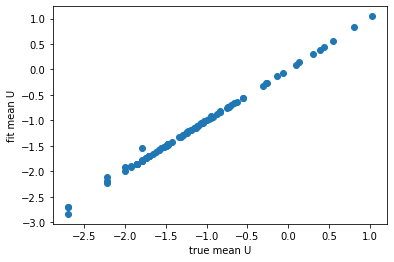

In [781]:
pred_mean = (sr.param_estimates[0][:,0]-sr.param_estimates[0][:,1])+all_params[0][0,:,4]
plt.scatter(np.log10(np.mean(k1[:,:,0],axis=0)),pred_mean)
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**pred_mean))

plt.xlabel('true mean U')
plt.ylabel('fit mean U')

[[nan nan]
 [nan  1.]]


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Fit Fano - 1')

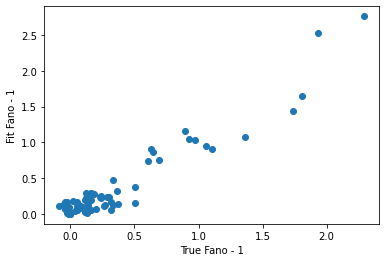

In [532]:
fano = np.var(k1[:,:,0],axis=0)/np.mean(k1[:,:,0],axis=0) - 1
pred_fano = 10**(params[0,:,4])*(1+10**params[0,:,0])

plt.scatter(fano,pred_fano)
print(np.corrcoef(fano,pred_fano))

plt.xlabel('True Fano - 1')
plt.ylabel('Fit Fano - 1')

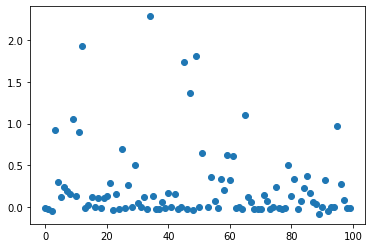

In [533]:
plt.scatter(range(len(fano)),fano)

(array([ 2.,  5.,  5., 14., 21., 17., 17., 10.,  3.,  6.]),
 array([-0.44154022, -0.14843812,  0.14466398,  0.43776608,  0.73086818,
         1.02397027,  1.31707237,  1.61017447,  1.90327657,  2.19637867,
         2.48948077]),
 <BarContainer object of 10 artists>)

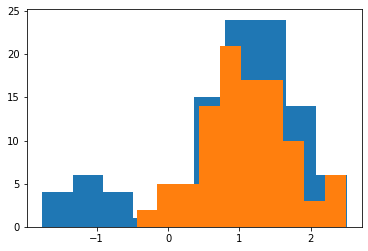

In [588]:
#Monod b dist overlap with true b dist
plt.hist(sr.param_estimates[0][:,0]) #Monod also not getting params right without EM
plt.hist(true_b0)

array([[1.        , 0.94245049],
       [0.94245049, 1.        ]])

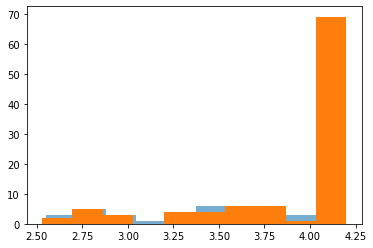

In [257]:
pred_b0 = grid_point_results[0].param_estimates[:,0,0]
plt.hist(sr.param_estimates[0][:,0],alpha=0.6)
plt.hist(pred_b0)
np.corrcoef(sr.param_estimates[0][:,0],pred_b0)

array([[1.        , 0.87494348],
       [0.87494348, 1.        ]])

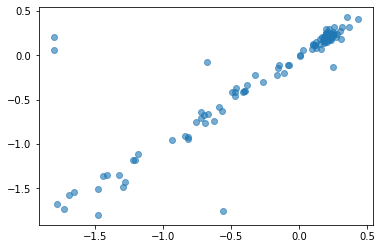

In [258]:
pred_b0 = grid_point_results_k3.param_estimates[:,1,0]
plt.scatter(sr.param_estimates[0][:,1],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,1],pred_b0)

array([[1.        , 0.49130319],
       [0.49130319, 1.        ]])

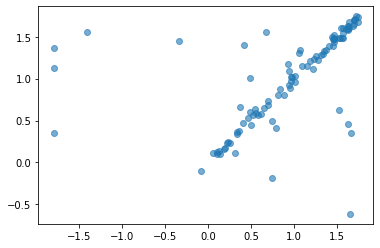

In [259]:
pred_b0 = grid_point_results_k3.param_estimates[:,2,0]
plt.scatter(sr.param_estimates[0][:,2],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,2],pred_b0)